<a href="https://colab.research.google.com/github/Haikal7090/TUBES-LIDEA-K7/blob/main/Tubes_lidea_ril_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependecies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from scipy import stats

# Load Data

In [ ]:
!pip install gdown
!gdown --fuzzy "https://docs.google.com/spreadsheets/d/1mhDBGeIt2b6-FFKrolccp6Jog7ZvhrZN/edit?usp=sharing&ouid=116842443111305752575&rtpof=true&sd=true"

Downloading...
From: https://drive.google.com/uc?id=1mhDBGeIt2b6-FFKrolccp6Jog7ZvhrZN
To: /content/1744774003471_Data_Tugas_Besar_FINAL.xlsx
100% 1.40M/1.40M [00:00<00:00, 127MB/s]


In [ ]:
df_raw = pd.read_excel("1744774003471_Data_Tugas_Besar_FINAL.xlsx")
df_raw.head()

NAME        DESCRIPTION  VALUE  UNITS  DATE_TIME            TAG  DATE_NO  \
0  AA1  AA1_91_9500062414    0.0  Sm3/d   20210401  91_9500062414    44287   
1  AA1  AA1_91_9500062414    0.0  Sm3/d   20210402  91_9500062414    44288   
2  AA1  AA1_91_9500062414    0.0  Sm3/d   20210403  91_9500062414    44289   
3  AA1  AA1_91_9500062414    0.0  Sm3/d   20210404  91_9500062414    44290   
4  AA1  AA1_91_9500062414    0.0  Sm3/d   20210405  91_9500062414    44291   

   Amount Comp_01  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

In [ ]:
df_raw.shape

(35200, 8)

In [ ]:
# Mengganti nilai 0 dengan NaN
df_raw = df_raw.replace(0, np.nan)

# Menghitung jumlah missing value per kolom
missing_values = df_raw.isnull().sum()

# Menghitung persentase missing value per kolom
missing_percentage = (missing_values / len(df_raw)) * 100

# Membuat dataframe untuk menampilkan jumlah dan persentase missing value
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print("Informasi Missing Value (termasuk nilai 0 yang dianggap NaN):")
print(missing_info)

# Anda juga bisa menampilkan kolom dengan missing value > 0
print("\nKolom dengan Missing Values:")
print(missing_info[missing_info['Missing Values'] > 0])

Informasi Missing Value (termasuk nilai 0 yang dianggap NaN):
                Missing Values  Percentage (%)
NAME                         0        0.000000
DESCRIPTION                  0        0.000000
VALUE                     2292        6.511364
UNITS                        0        0.000000
DATE_TIME                    0        0.000000
TAG                          0        0.000000
DATE_NO                      0        0.000000
Amount Comp_01            2292        6.511364

Kolom dengan Missing Values:
                Missing Values  Percentage (%)
VALUE                     2292        6.511364
Amount Comp_01            2292        6.511364


In [ ]:
# Mengecek data duplikat
duplicate_rows = df_raw[df_raw.duplicated()]

print("\nJumlah data duplikat:", duplicate_rows.shape[0])

if duplicate_rows.shape[0] > 0:
    print("\nContoh data duplikat:")
    print(duplicate_rows.head())
else:
    print("\nTidak ada data duplikat ditemukan.")

# Jika Anda ingin melihat baris yang sepenuhnya sama, Anda bisa menggunakan keep=False
# all_duplicate_rows = df_raw[df_raw.duplicated(keep=False)]
# print("\nSemua baris duplikat:")
# print(all_duplicate_rows)


Jumlah data duplikat: 0

Tidak ada data duplikat ditemukan.


In [ ]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.shape[0]

def detect_outliers_zscore(df, column, threshold=3):
    df_cleaned = df.dropna(subset=[column]) # Z-score is sensitive to NaN
    if df_cleaned.empty:
        return 0
    z_scores = np.abs(zscore(df_cleaned[column]))
    outliers = df_cleaned[z_scores > threshold]
    return outliers.shape[0]

# Identify numerical columns to check for outliers (excluding 'No' and potentially others if not numerical)
numerical_cols = df_raw.select_dtypes(include=np.number).columns.tolist()
if 'No' in numerical_cols:
    numerical_cols.remove('No')

print("\nDeteksi Outlier per Kolom:")
print("-" * 30)

for col in numerical_cols:
    iqr_outliers = detect_outliers_iqr(df_raw, col)
    zscore_outliers = detect_outliers_zscore(df_raw, col)

    print(f"Kolom '{col}':")
    print(f"  Jumlah outlier (IQR): {iqr_outliers}")
    print(f"  Jumlah outlier (Z-score): {zscore_outliers}")
    print("-" * 30)



Deteksi Outlier per Kolom:
------------------------------
Kolom 'VALUE':
  Jumlah outlier (IQR): 1013
  Jumlah outlier (Z-score): 703
------------------------------
Kolom 'DATE_TIME':
  Jumlah outlier (IQR): 0
  Jumlah outlier (Z-score): 0
------------------------------
Kolom 'DATE_NO':
  Jumlah outlier (IQR): 0
  Jumlah outlier (Z-score): 0
------------------------------
Kolom 'Amount Comp_01':
  Jumlah outlier (IQR): 1013
  Jumlah outlier (Z-score): 703
------------------------------


In [ ]:
df_raw.shape

(35200, 8)

# Data Wrangling

In [ ]:
# Hapus kolom yang tidak diperlukan
df = df_raw.copy()
df.drop(columns=['DATE_NO', 'TAG', 'Amount Comp_01', 'NAME'], inplace=True, errors='ignore')

# Pivot: setiap kolom adalah satu DESCRIPTION, isinya VALUE, baris berdasarkan DATE_TIME
pivot_df = df.pivot(index='DATE_TIME', columns='DESCRIPTION', values='VALUE')

# Ambil hanya 640 baris pertama dari index 0
pivot_df = pivot_df.iloc[0:640]

# Simpan ke file Excel baru
output_pivot = "pivot_55_description_640rows.xlsx"
pivot_df.to_excel(output_pivot)

print(f"Data pivot dengan 55 kolom DESCRIPTION dan 640 baris DATE_TIME telah disimpan di: {output_pivot}")

Data pivot dengan 55 kolom DESCRIPTION dan 640 baris DATE_TIME telah disimpan di: pivot_55_description_640rows.xlsx


In [ ]:
df = pd.read_excel('pivot_55_description_640rows.xlsx')
df.head()

DATE_TIME  AA1_91_9500062414  AA1_91_EP_NATURAL_GAS  AA1_ANPR  AA1_ANTP  \
0   20210401                NaN                    NaN       NaN       NaN   
1   20210402                NaN                    NaN       NaN       NaN   
2   20210403                NaN                    NaN       NaN       NaN   
3   20210404                NaN                    NaN       NaN       NaN   
4   20210405                NaN                    NaN       NaN       NaN   

   AA1_C_OP  AA1_C_PR  AA1_C_TE  AA1_FBHP  AA1_FBHT  ...  \
0       NaN       NaN       NaN       NaN       NaN  ...   
1       NaN       NaN       NaN       NaN       NaN  ...   
2       NaN       NaN       NaN       NaN       NaN  ...   
3       NaN       NaN       NaN       NaN       NaN  ...   
4       NaN       NaN       NaN       NaN       NaN  ...   

   AA5_91_EP_NATURAL_GAS  AA5_ANPR  AA5_ANTP  AA5_C_OP  AA5_C_PR  AA5_C_TE  \
0                    NaN       NaN       NaN       NaN       NaN       NaN   
1                    NaN       NaN       NaN       NaN       NaN       NaN   
2                    NaN       NaN       NaN       NaN       NaN       NaN   
3                    NaN       NaN       NaN       NaN       NaN       NaN   
4                    NaN       NaN       NaN       NaN       NaN       NaN   

   AA5_FBHP  AA5_FBHT  AA5_FTHP  AA5_FTHT  
0       NaN       NaN       NaN       NaN  
1       NaN       NaN       NaN       NaN  
2       NaN       NaN       NaN       NaN  
3       NaN       NaN       NaN       NaN  
4       NaN       NaN       NaN       NaN  

[5 rows x 56 columns]

In [ ]:
# Convert DATE_TIME to datetime
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y%m%d')

In [ ]:
df.shape

(640, 56)

# Explanatory Data Analysis

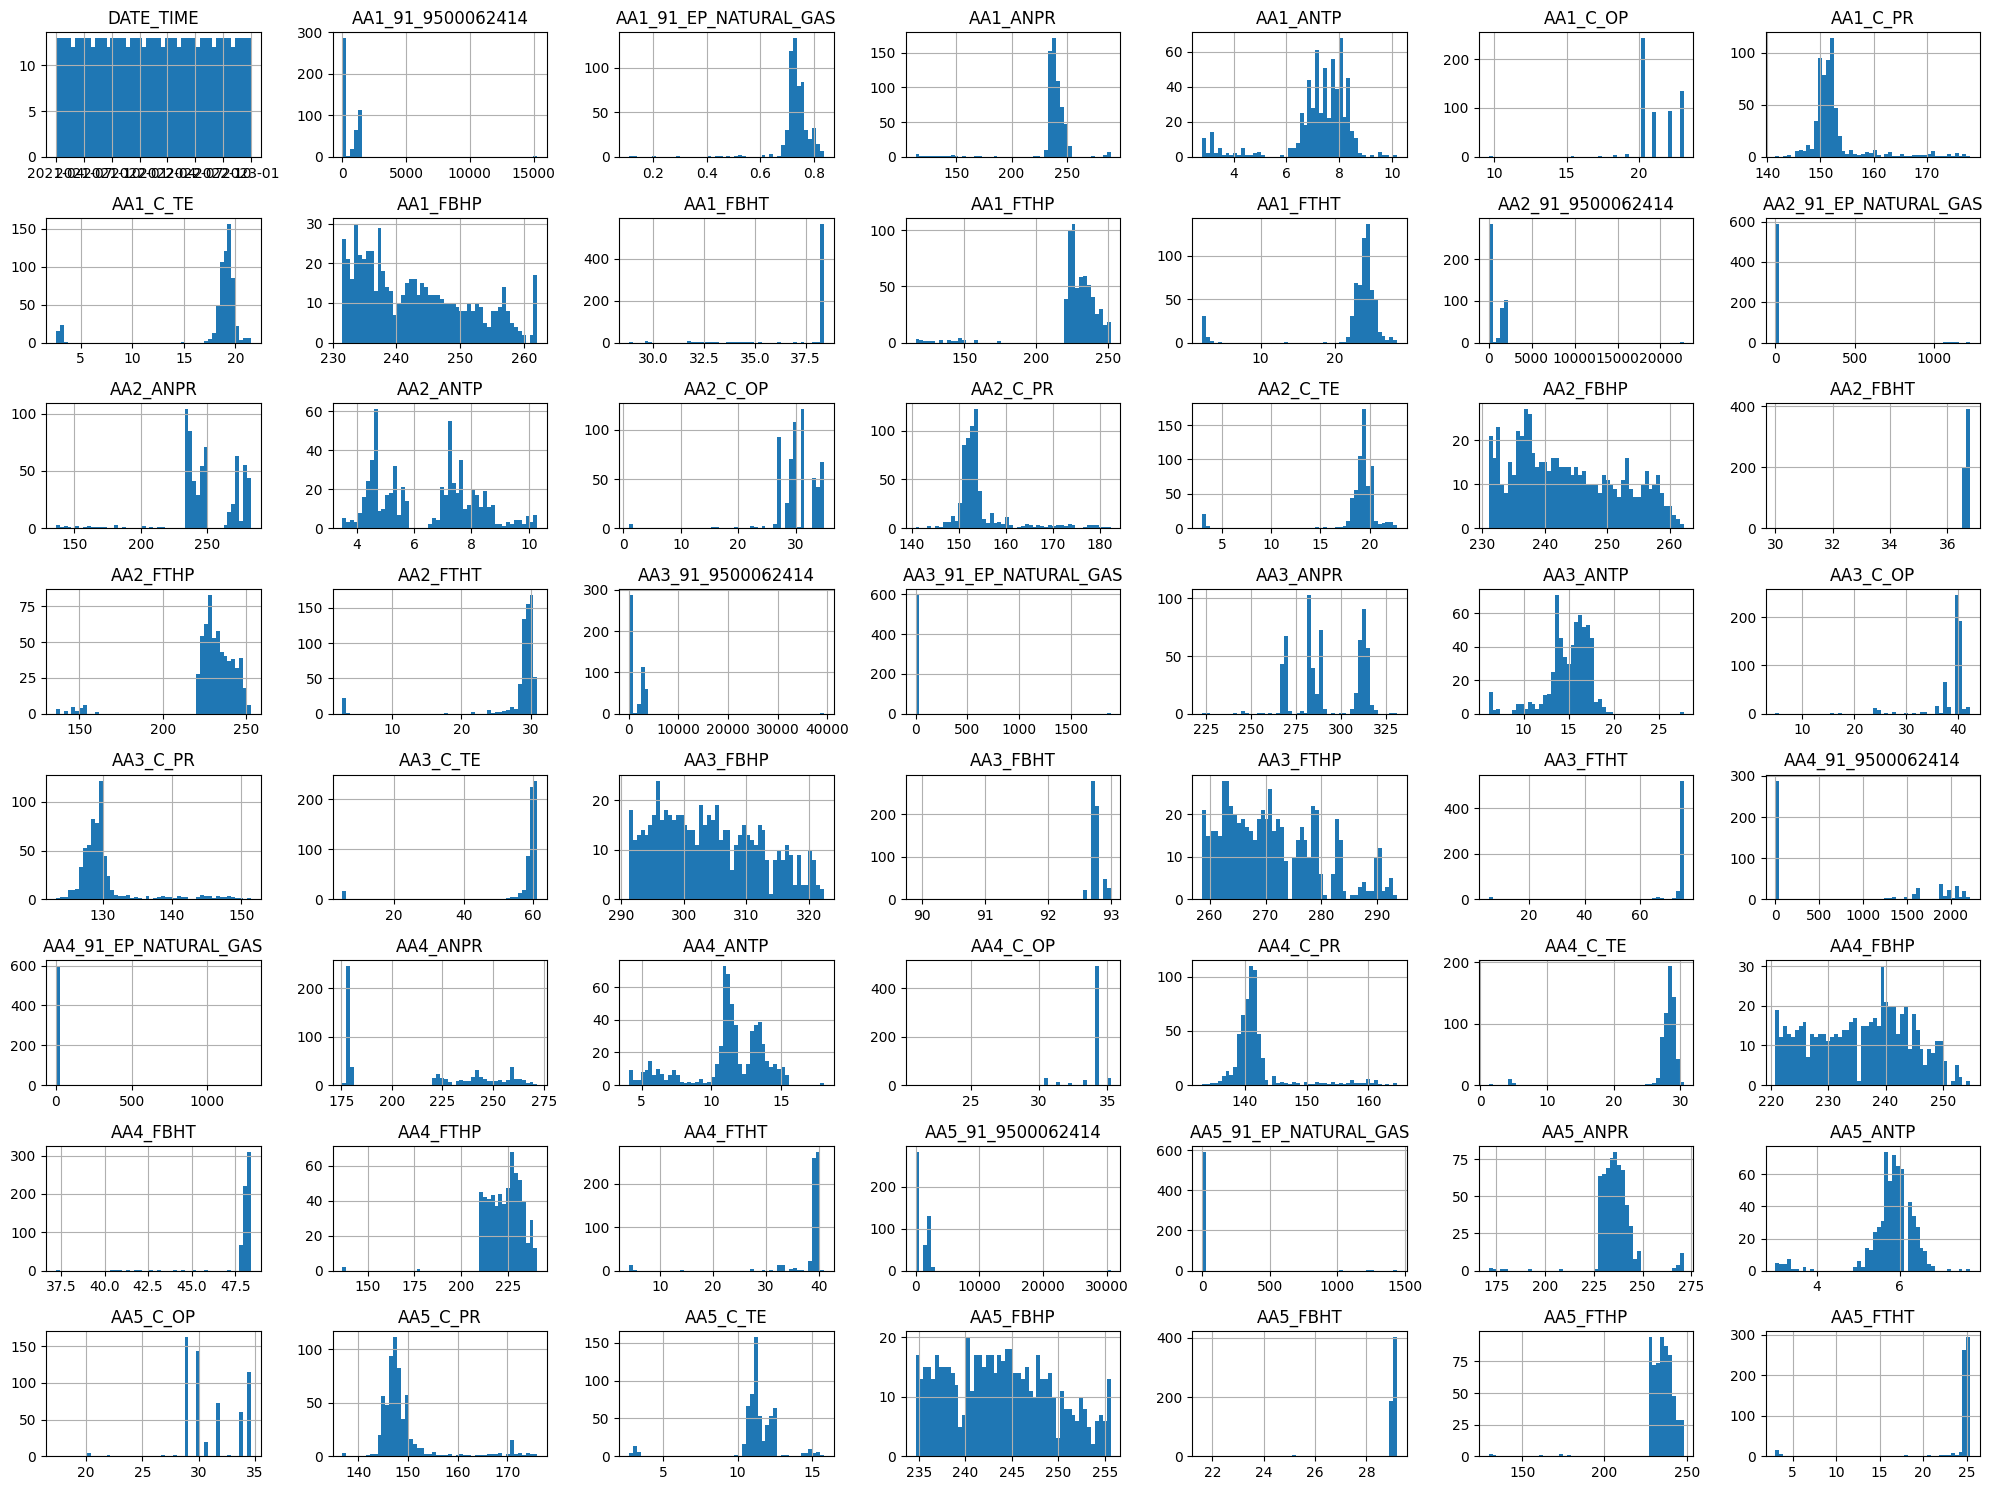

In [ ]:
# Grafik histogram untuk semua kolom
df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

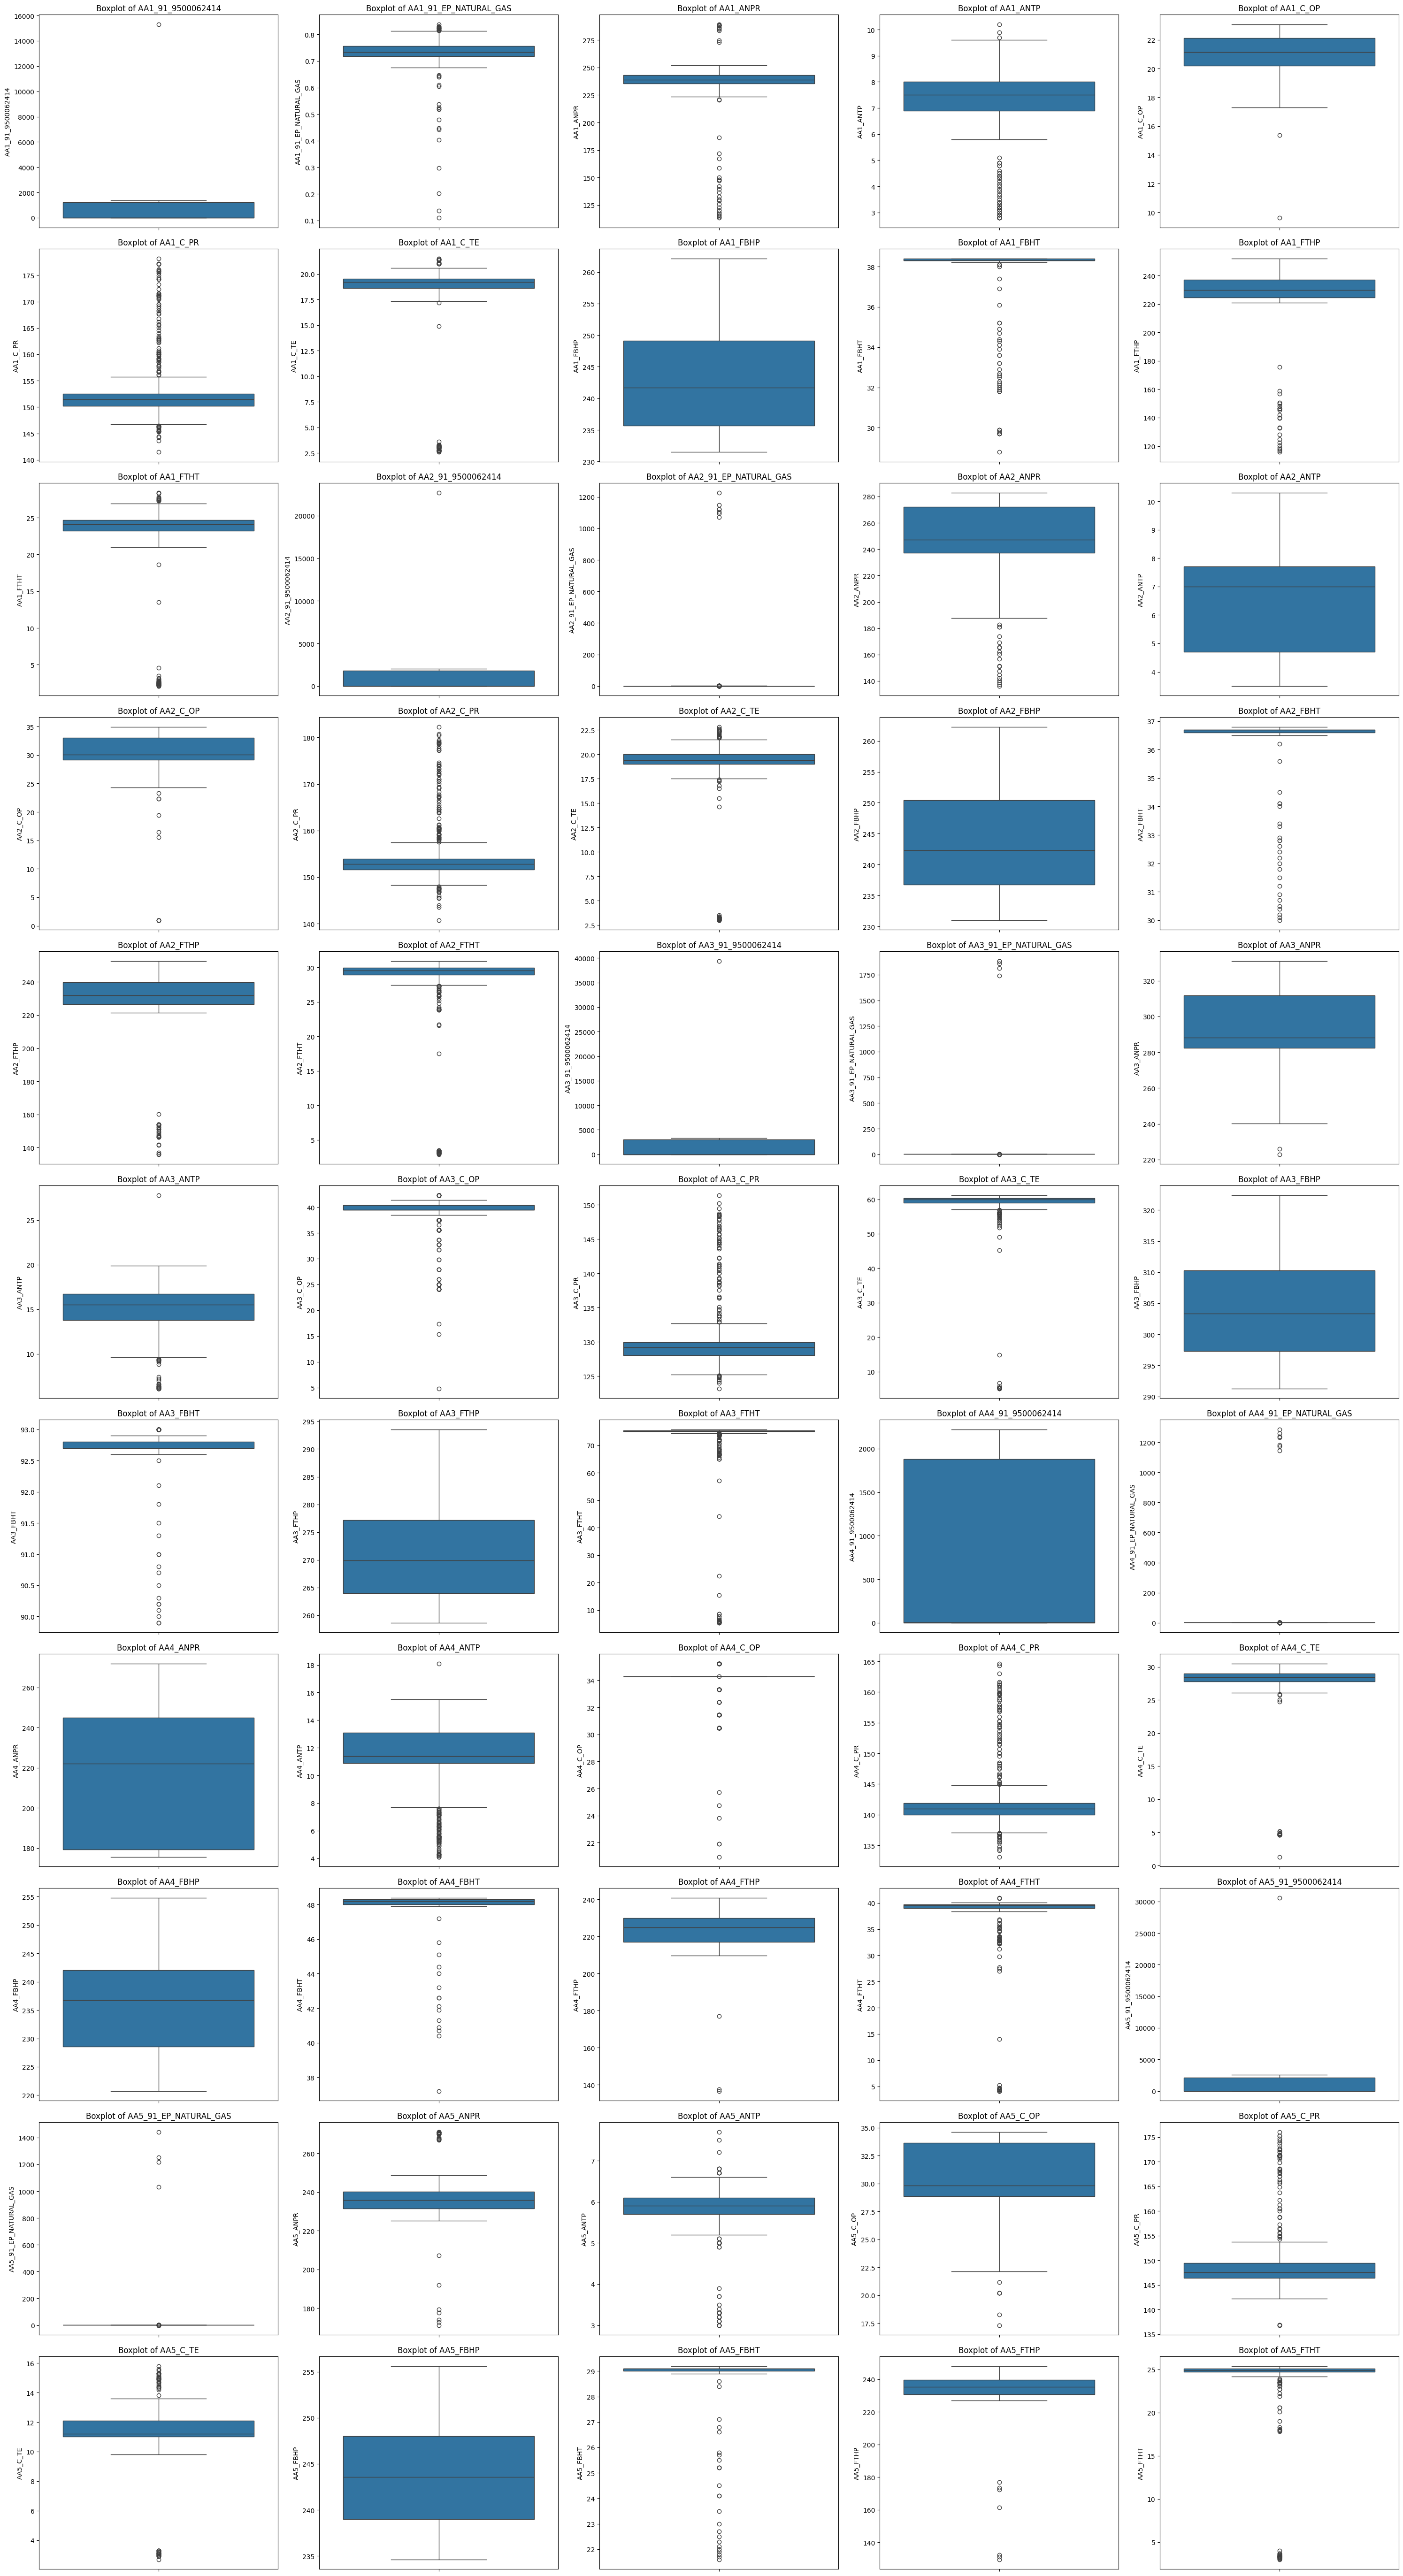

In [ ]:
# Plotting boxplots for numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Determine the number of rows and columns for the subplot grid
n_cols = 5
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

# Adjust figure size
plt.figure(figsize=(6 * n_cols, 5 * n_rows)) # Adjust the overall figure size

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col) # Set the y-axis label
plt.savefig('box-plot-before-cleaning.png') # Save the heatmap
plt.tight_layout()
plt.show()

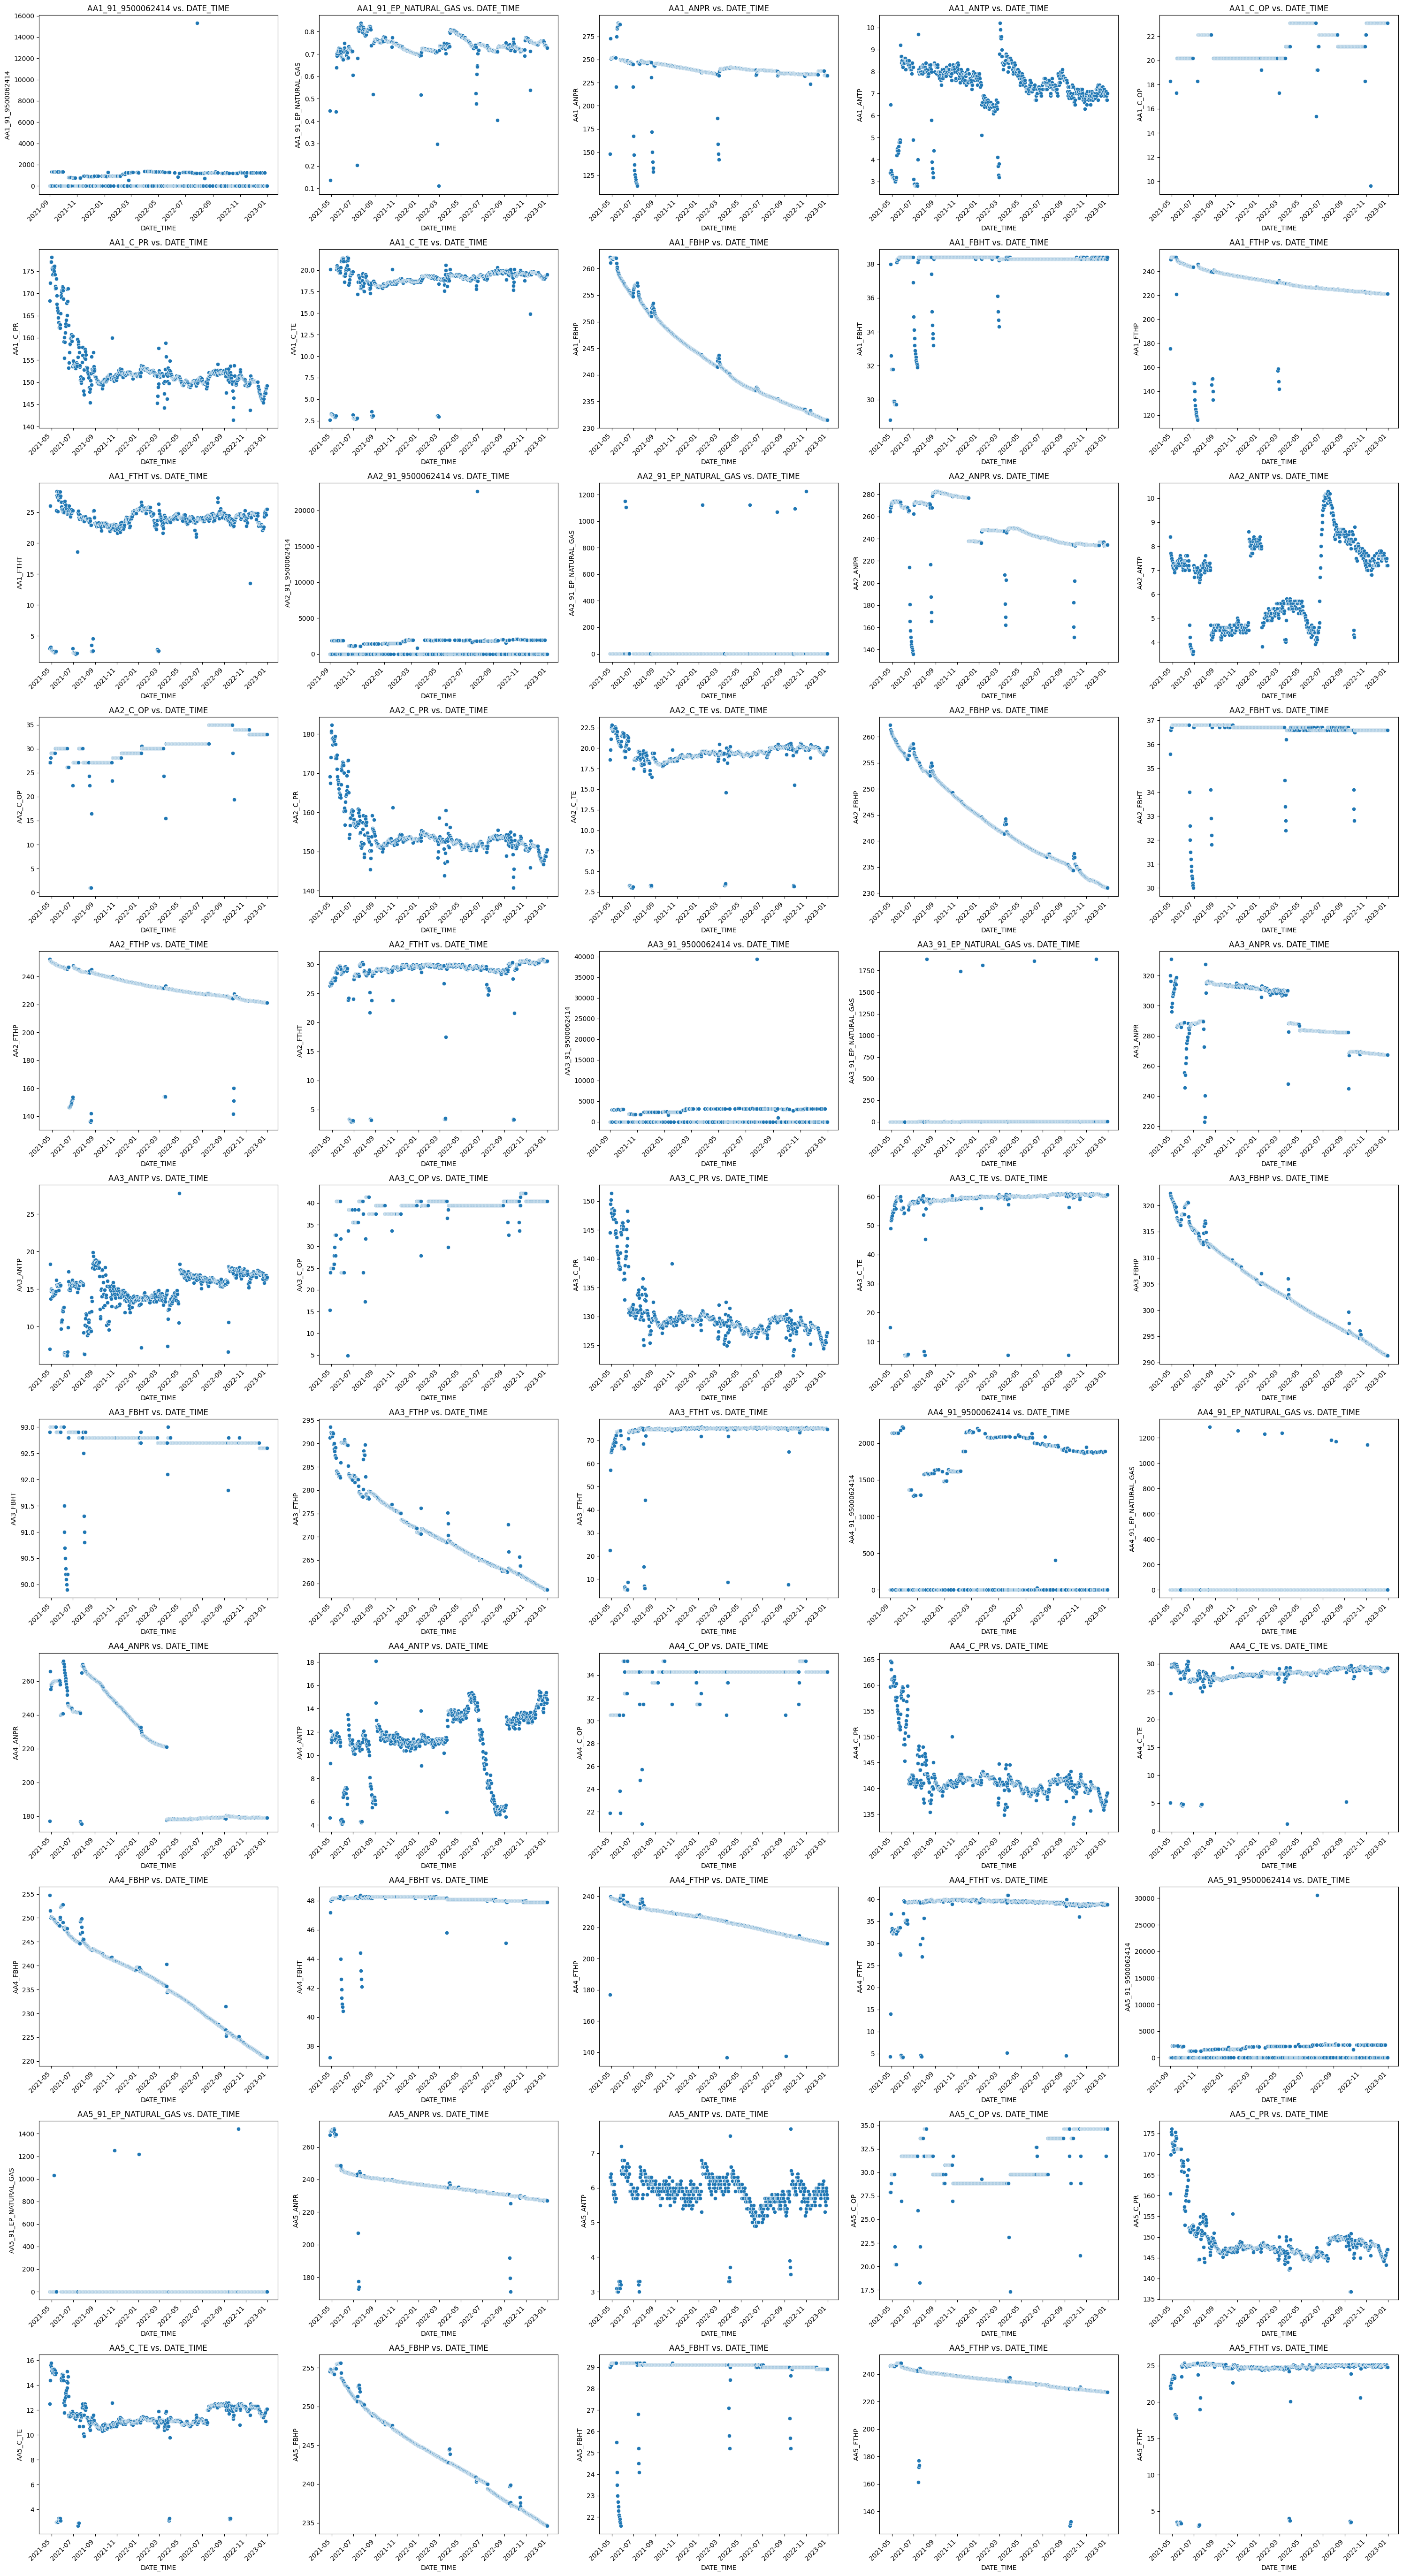

In [ ]:
# Get the list of columns excluding 'DATE_TIME'
columns_to_plot = df.columns.drop('DATE_TIME')

# Determine the number of rows and columns for the subplot grid
n_cols = 5
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

# Adjust figure size (6x5 inches per subplot)
plt.figure(figsize=(6 * n_cols, 5 * n_rows))

# Create a scatter plot for each column against 'DATE_TIME'
for i, col in enumerate(columns_to_plot):
    plt.subplot(n_rows, n_cols, i + 1) # Select the subplot
    sns.scatterplot(x=df['DATE_TIME'], y=df[col]) # Create the scatter plot
    plt.title(f'{col} vs. DATE_TIME') # Set title
    plt.xlabel('DATE_TIME') # Set x-axis label
    plt.ylabel(col) # Set y-axis label
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plot

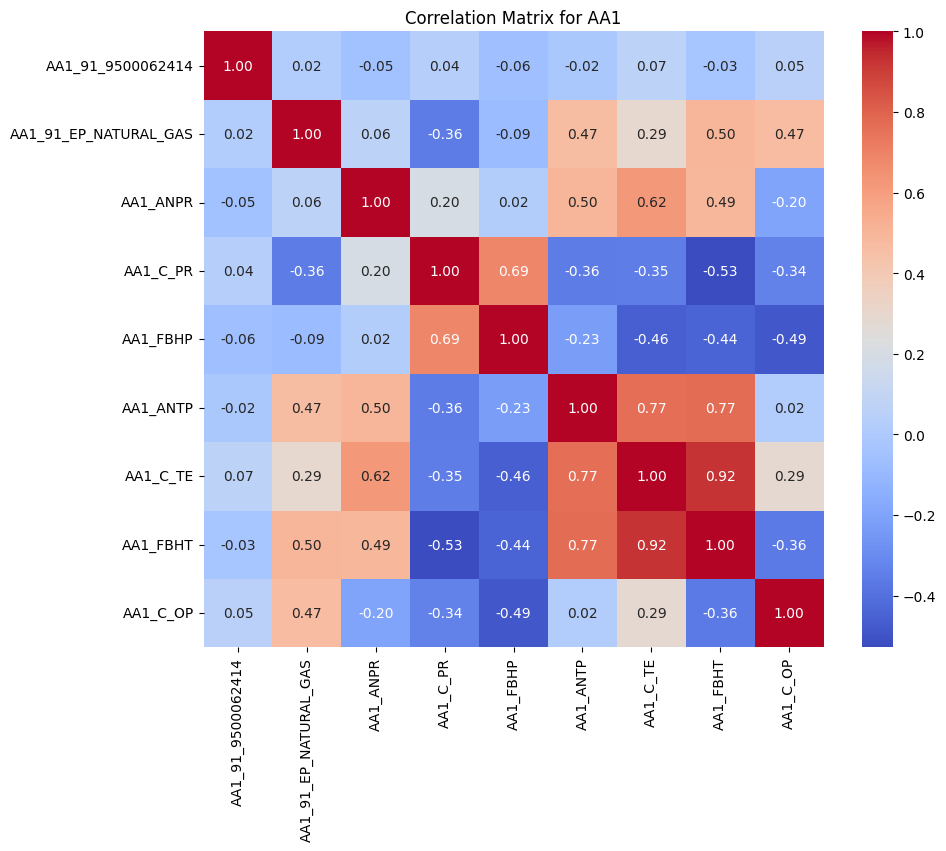

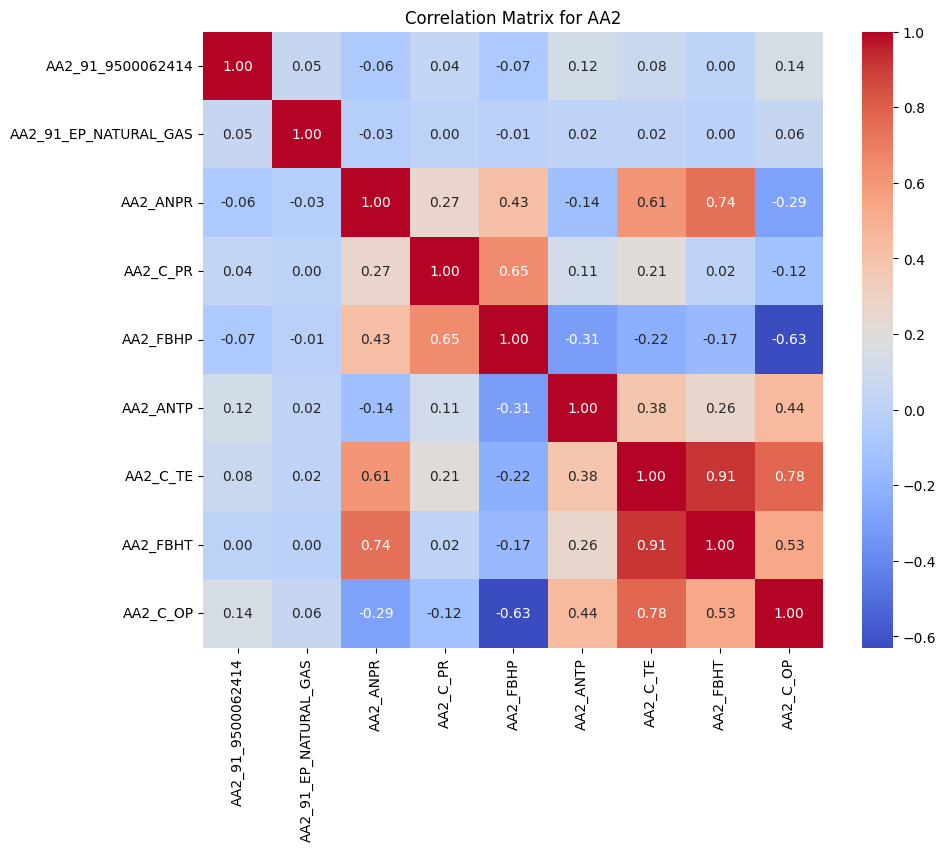

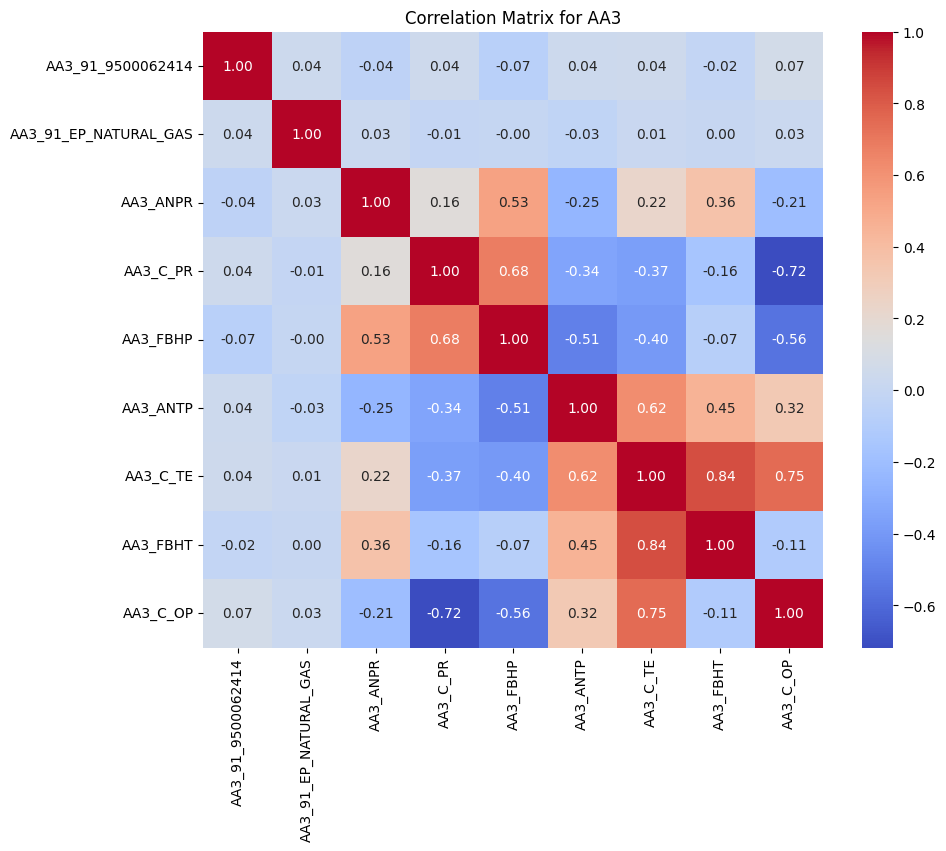

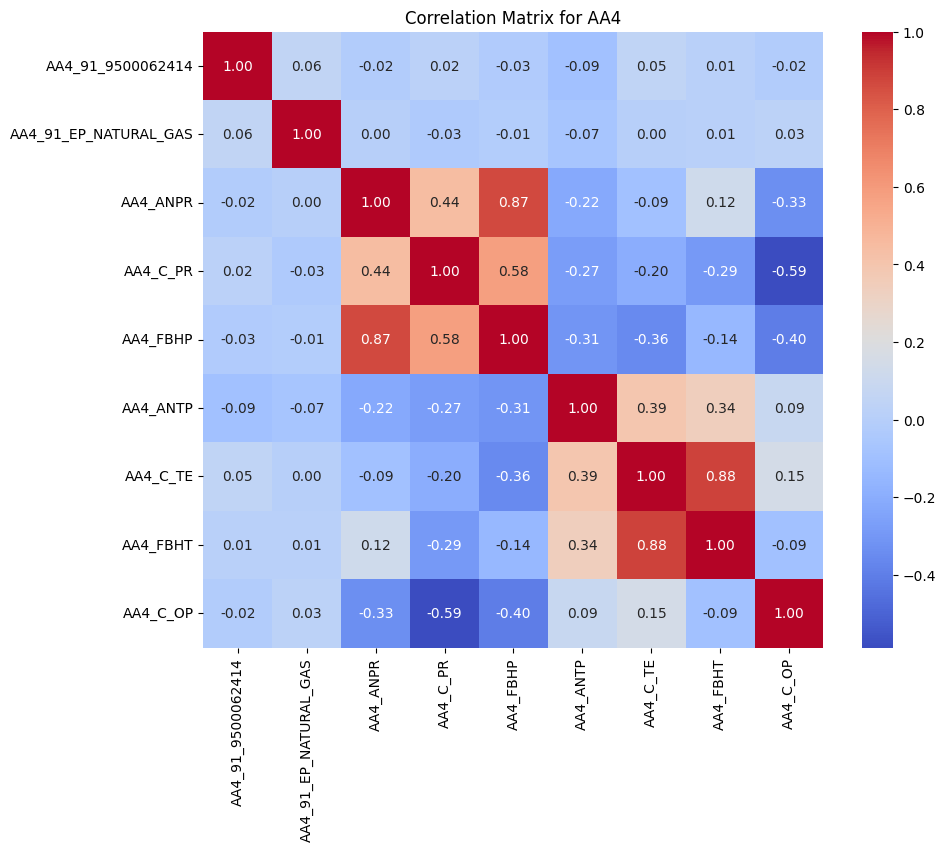

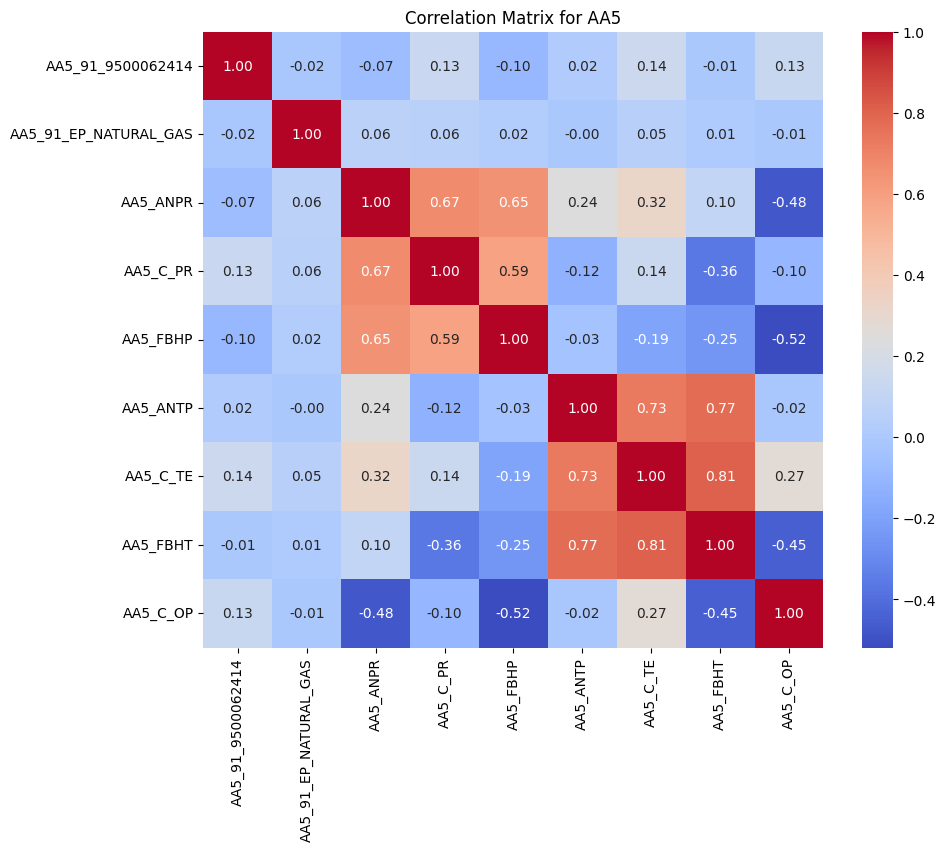

In [ ]:
# Key variables for each well
key_variables = ['91_9500062414', '91_EP_NATURAL_GAS', 'ANPR', 'C_PR', 'FBHP', 'ANTP', 'C_TE', 'FBHT', 'C_OP']

# Iterate through each well
for well in ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']:
    well_data = df[[f'{well}_{var}' for var in key_variables]]
    correlation_matrix = well_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {well}')
    plt.savefig(f'{well}_heatmap.png') # Save the heatmap
    plt.show()

# DATA CLEANING

In [ ]:
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(data, lower_bound, upper_bound)

for col in df.columns:
    if col != 'DATE_TIME':
        df[col] = remove_outliers_iqr(df[col])
        df[col] = df[col].replace(0, np.nan)
        # Try linear interpolation first
        df[col] = df[col].interpolate(method='linear')
        # If there are still NaNs after linear interpolation (likely due to large gaps), use forward and backward fill
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

display(df.head())

<ipython-input-21-ead471dfe487>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-ead471dfe487>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-ead471dfe487>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-ead471dfe487>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-ead471dfe487>:16: FutureWarning: Series.fi

DATE_TIME  AA1_91_9500062414  AA1_91_EP_NATURAL_GAS   AA1_ANPR  AA1_ANTP  \
0 2021-04-01               1.34               0.651623  223.54125      5.25   
1 2021-04-02               1.34               0.651623  223.54125      5.25   
2 2021-04-03               1.34               0.651623  223.54125      5.25   
3 2021-04-04               1.34               0.651623  223.54125      5.25   
4 2021-04-05               1.34               0.651623  223.54125      5.25   

   AA1_C_OP   AA1_C_PR  AA1_C_TE  AA1_FBHP  AA1_FBHT  ...  \
0     18.27  156.62375     17.25    262.13     38.15  ...   
1     18.27  156.62375     17.25    262.13     38.15  ...   
2     18.27  156.62375     17.25    262.13     38.15  ...   
3     18.27  156.62375     17.25    262.13     38.15  ...   
4     18.27  156.62375     17.25    262.13     38.15  ...   

   AA5_91_EP_NATURAL_GAS   AA5_ANPR  AA5_ANTP  AA5_C_OP   AA5_C_PR  AA5_C_TE  \
0               0.899936  254.12125       6.3     27.88  154.65375      12.5   
1               0.899936  254.12125       6.3     27.88  154.65375      12.5   
2               0.899936  254.12125       6.3     27.88  154.65375      12.5   
3               0.899936  254.12125       6.3     27.88  154.65375      12.5   
4               0.899936  254.12125       6.3     27.88  154.65375      12.5   

   AA5_FBHP  AA5_FBHT  AA5_FTHP  AA5_FTHT  
0    254.54      29.0    245.98      24.1  
1    254.54      29.0    245.98      24.1  
2    254.54      29.0    245.98      24.1  
3    254.54      29.0    245.98      24.1  
4    254.54      29.0    245.98      24.1  

[5 rows x 56 columns]

In [ ]:
df.shape

(640, 56)

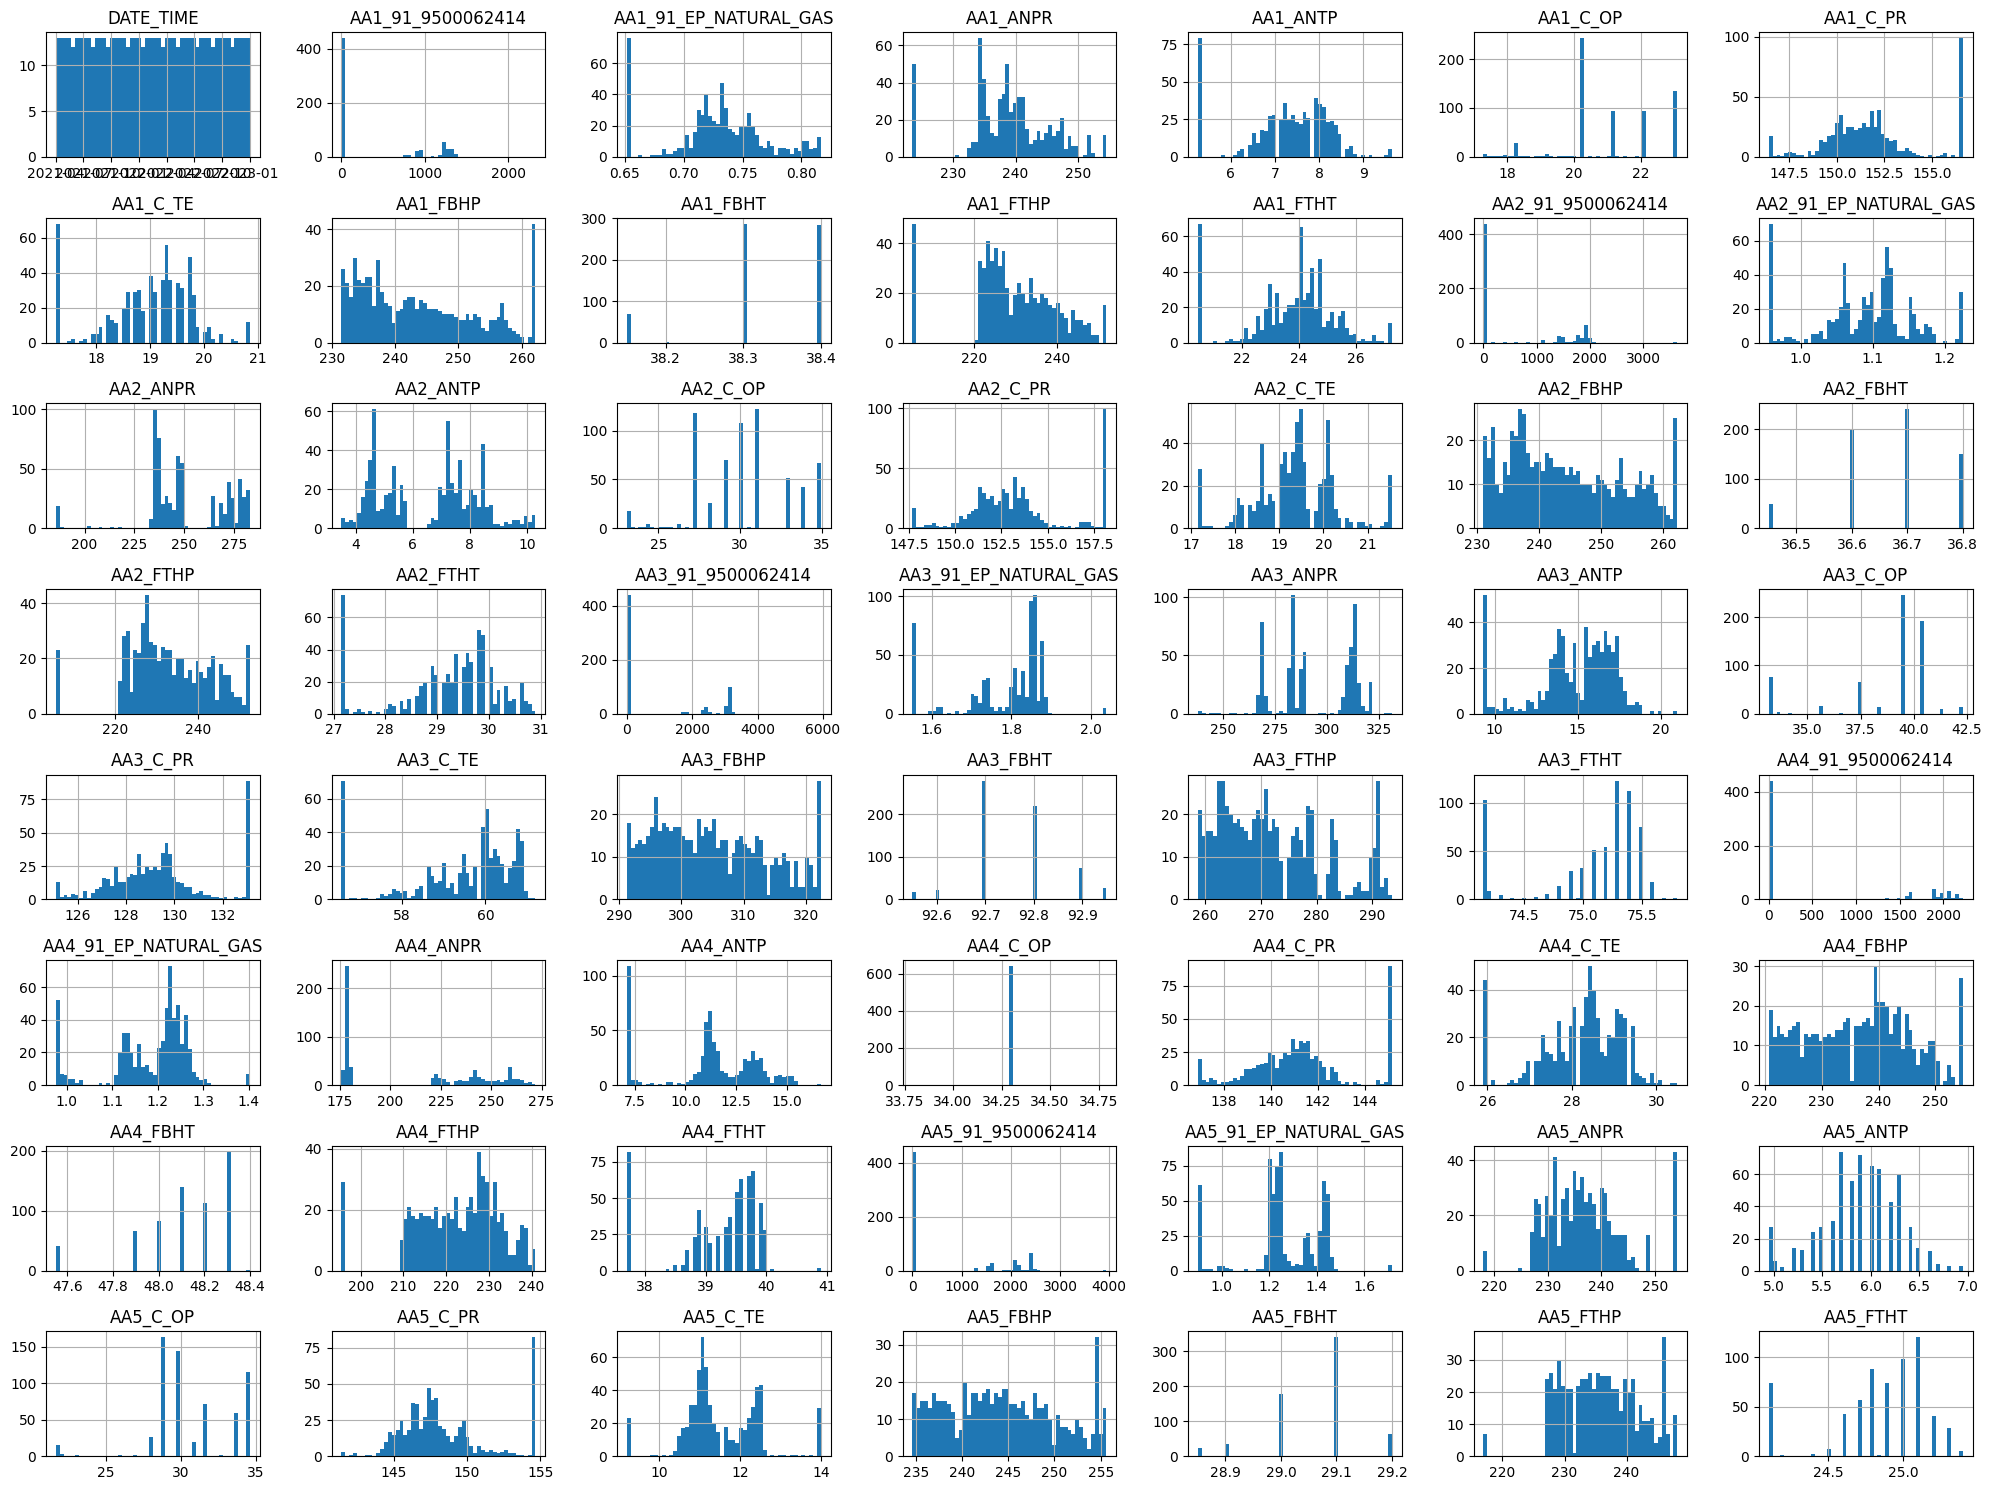

In [ ]:
# Grafik Histogram untuk semua kolom setelah data cleaning

df.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

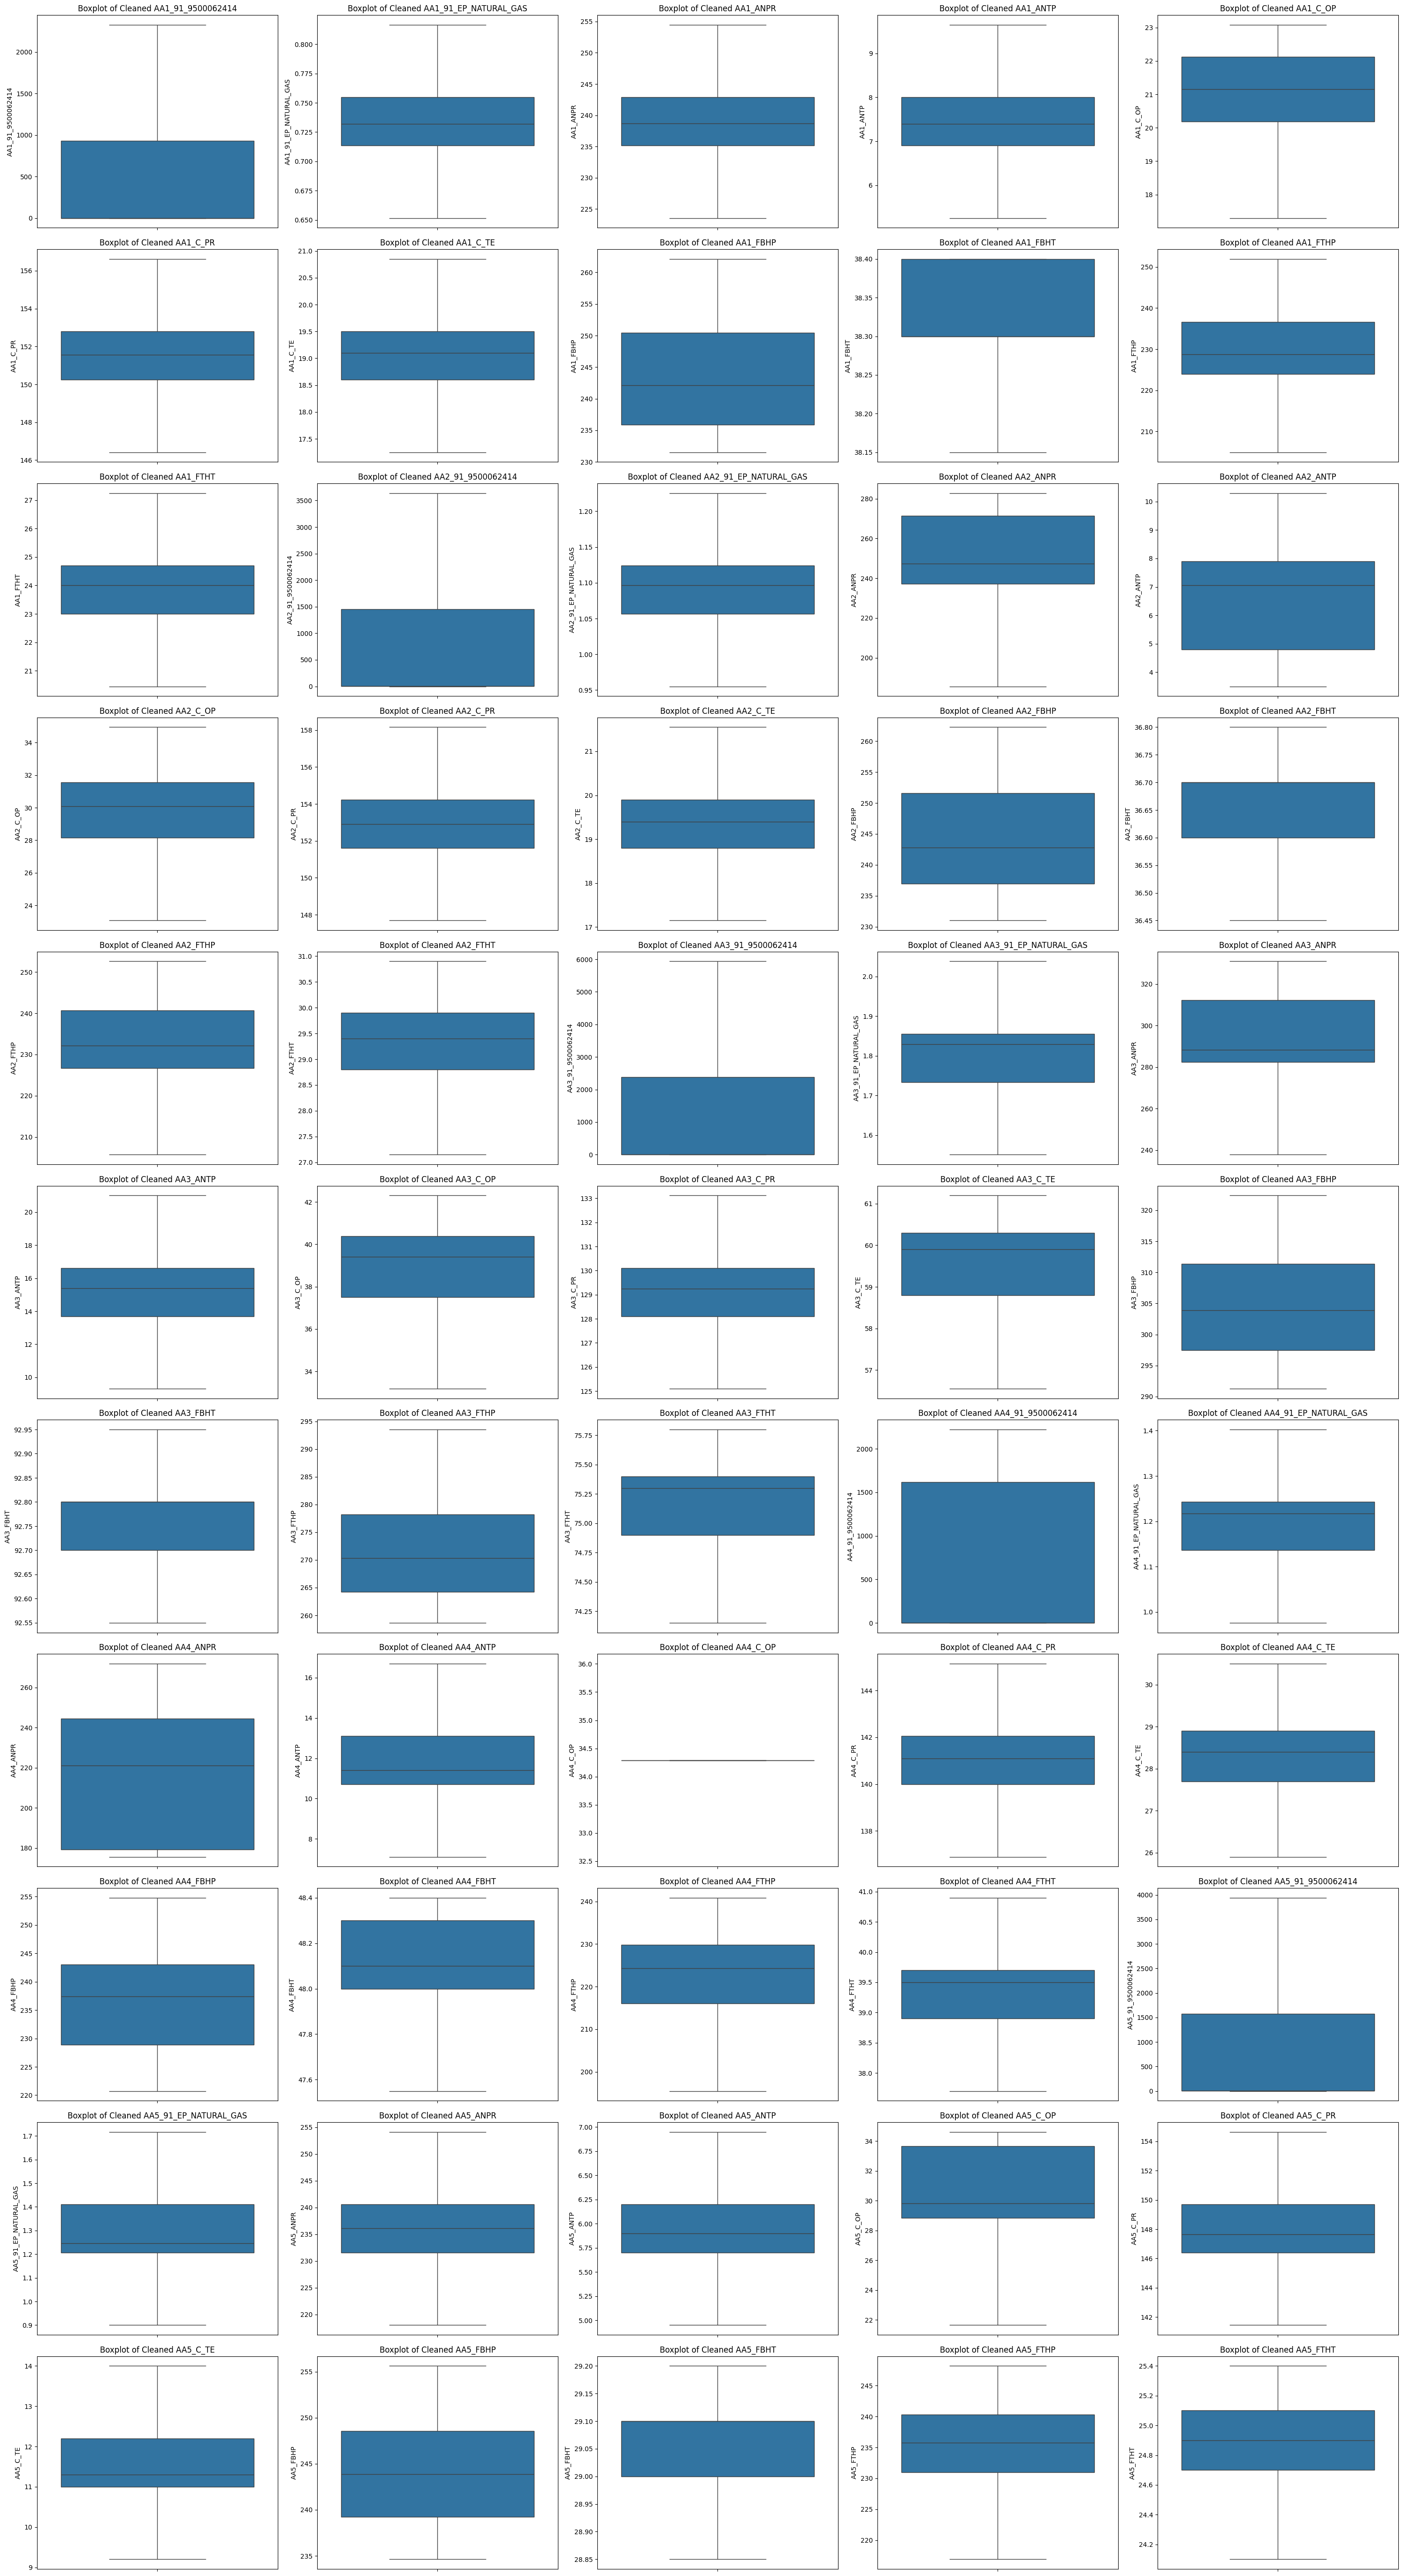

In [ ]:
# prompt: Buatkan aku kode boxplot yang dapat melihat oulier yang sudah bersih buat jadi gambar 6x5

# Plotting boxplots for numerical columns after cleaning
numerical_cols_cleaned = df.select_dtypes(include=np.number).columns.tolist()

# Determine the number of rows and columns for the subplot grid
n_cols = 5
n_rows = int(np.ceil(len(numerical_cols_cleaned) / n_cols))

# Adjust figure size for 6x5 inches per subplot
plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, col in enumerate(numerical_cols_cleaned):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of Cleaned {col}')
    plt.ylabel(col) # Set the y-axis label

plt.tight_layout()
plt.show()


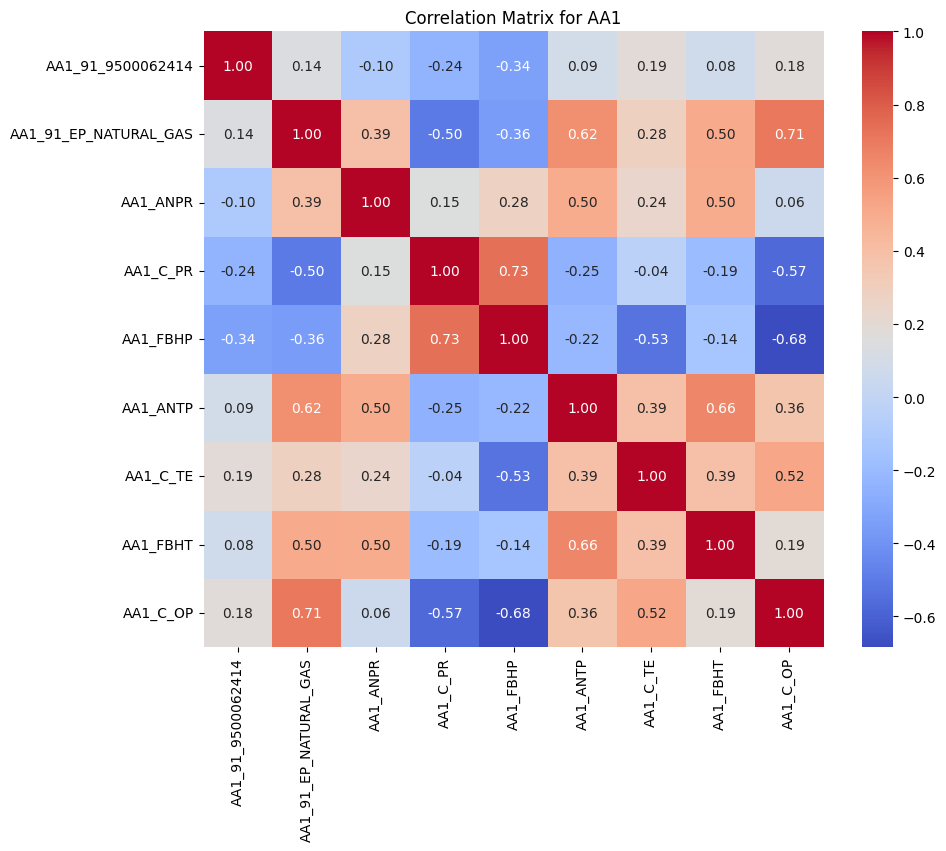

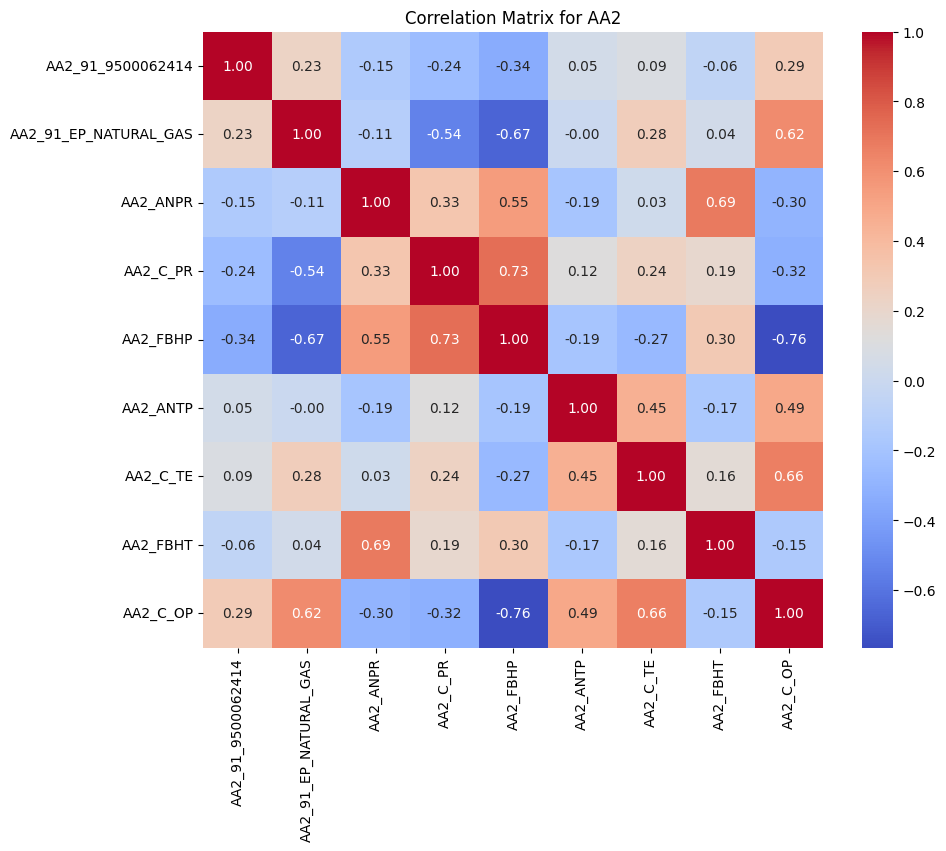

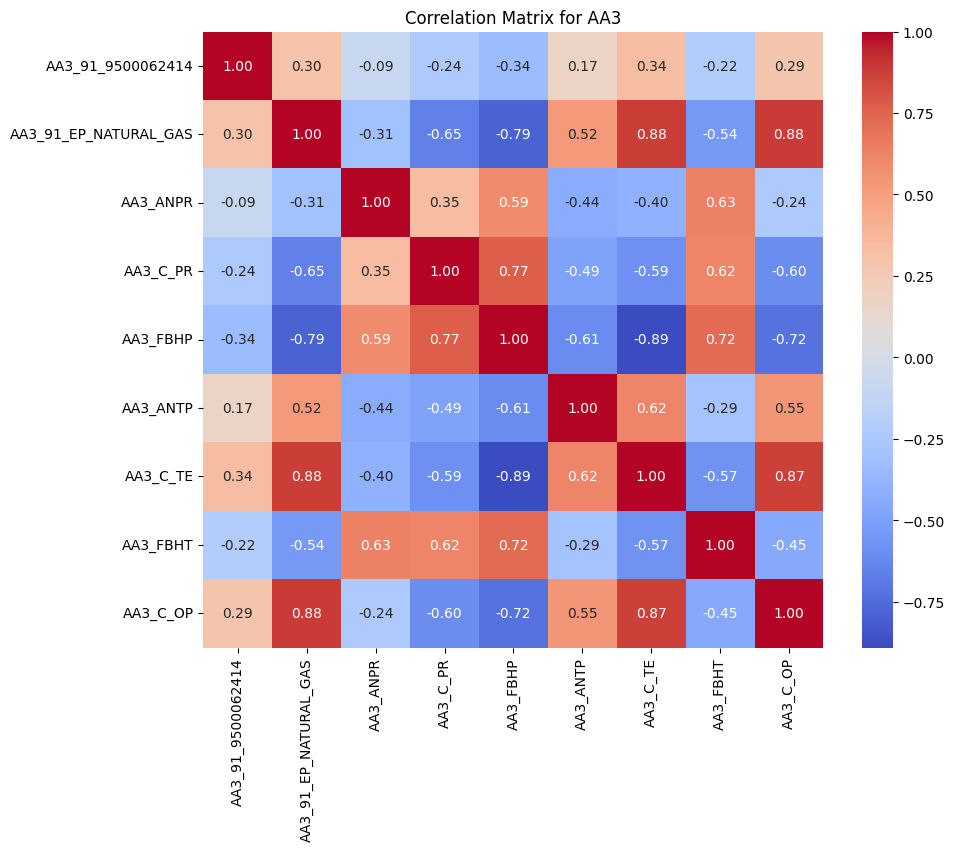

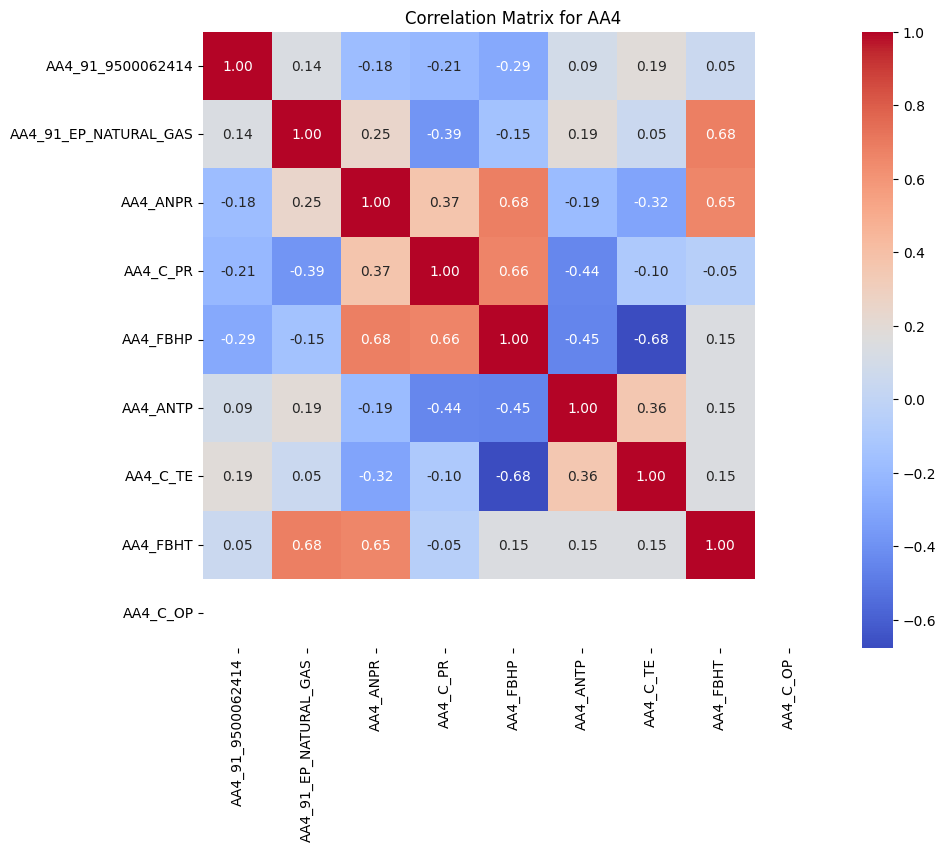

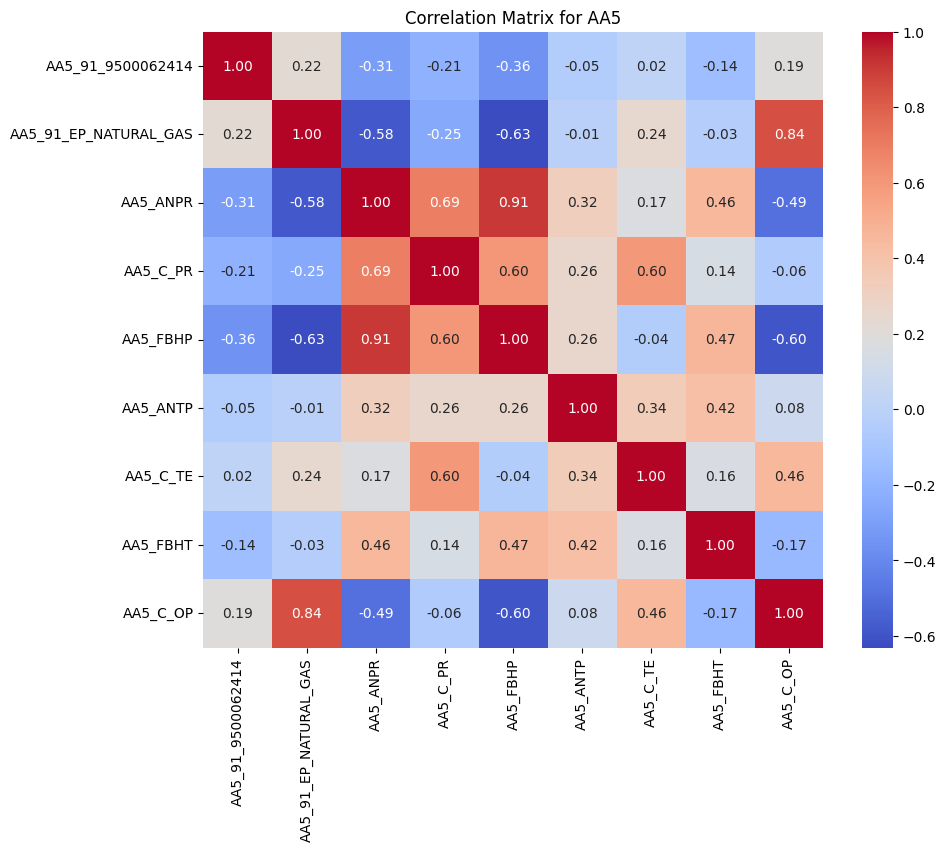

In [ ]:
# Key variables for each well
key_variables = ['91_9500062414', '91_EP_NATURAL_GAS', 'ANPR', 'C_PR', 'FBHP', 'ANTP', 'C_TE', 'FBHT', 'C_OP']

# Iterate through each well
for well in ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']:
    well_data = df[[f'{well}_{var}' for var in key_variables]]
    correlation_matrix = well_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {well}')
    plt.savefig(f'{well}_heatmap.png') # Save the heatmap
    plt.show()

In [ ]:
# prompt: save data yang sudah bersih ke excel

# Define the output filename for the cleaned data
output_cleaned_excel = "cleaned_data_640rows.xlsx"

# Save the cleaned dataframe to an Excel file
df.to_excel(output_cleaned_excel, index=False)

print(f"Data yang sudah bersih telah disimpan ke: {output_cleaned_excel}")

# Making a model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR

# Function to create and evaluate models for each well
def evaluate_models(X, y, well_name):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(kernel='rbf')
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Cross validation score
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

        results[name] = {
            'RMSE': rmse,
            'R2': r2,
            'CV_R2_mean': cv_scores.mean(),
            'CV_R2_std': cv_scores.std(),
            'model': model,
            'scaler': scaler
        }

    print(f"\nResults for {well_name}:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"R2 Score: {metrics['R2']:.4f}")
        print(f"Cross-val R2: {metrics['CV_R2_mean']:.4f} (+/- {metrics['CV_R2_std']*2:.4f})")

    return results

# Prepare data for each well
wells = {
    'AA1': {
        'features': ['AA1_91_9500062414', 'AA1_ANPR', 'AA1_ANTP', 'AA1_C_OP', 'AA1_C_PR',
                    'AA1_C_TE', 'AA1_FBHP', 'AA1_FBHT', 'AA1_FTHP', 'AA1_FTHT'],
        'target': 'AA1_91_EP_NATURAL_GAS'
    },
    'AA2': {
        'features': ['AA2_91_9500062414', 'AA2_ANPR', 'AA2_ANTP', 'AA2_C_OP', 'AA2_C_PR',
                    'AA2_C_TE', 'AA2_FBHP', 'AA2_FBHT', 'AA2_FTHP', 'AA2_FTHT'],
        'target': 'AA2_91_EP_NATURAL_GAS'
    },
    'AA3': {
        'features': ['AA3_91_9500062414', 'AA3_ANPR', 'AA3_ANTP', 'AA3_C_OP', 'AA3_C_PR',
                    'AA3_C_TE', 'AA3_FBHP', 'AA3_FBHT', 'AA3_FTHP', 'AA3_FTHT'],
        'target': 'AA3_91_EP_NATURAL_GAS'
    },
    'AA4': {
        'features': ['AA4_91_9500062414', 'AA4_ANPR', 'AA4_ANTP', 'AA4_C_OP', 'AA4_C_PR',
                    'AA4_C_TE', 'AA4_FBHP', 'AA4_FBHT', 'AA4_FTHP', 'AA4_FTHT'],
        'target': 'AA4_91_EP_NATURAL_GAS'
    },
    'AA5': {
        'features': ['AA5_91_9500062414', 'AA5_ANPR', 'AA5_ANTP', 'AA5_C_OP', 'AA5_C_PR',
                    'AA5_C_TE', 'AA5_FBHP', 'AA5_FBHT', 'AA5_FTHP', 'AA5_FTHT'],
        'target': 'AA5_91_EP_NATURAL_GAS'
    }
}

# Train and evaluate models for each well
all_results = {}
for well_name, well_data in wells.items():
    X = df[well_data['features']]
    y = df[well_data['target']]
    all_results[well_name] = evaluate_models(X, y, well_name)


Results for AA1:

Linear Regression:
RMSE: 0.0197
R2 Score: 0.7492
Cross-val R2: 0.7725 (+/- 0.0487)

Random Forest:
RMSE: 0.0072
R2 Score: 0.9670
Cross-val R2: 0.9294 (+/- 0.0811)

XGBoost:
RMSE: 0.0079
R2 Score: 0.9599
Cross-val R2: 0.9157 (+/- 0.0929)

Gradient Boosting:
RMSE: 0.0087
R2 Score: 0.9510
Cross-val R2: 0.9060 (+/- 0.0718)

SVR:
RMSE: 0.0397
R2 Score: -0.0196
Cross-val R2: -0.0140 (+/- 0.0272)

Results for AA2:

Linear Regression:
RMSE: 0.0251
R2 Score: 0.8622
Cross-val R2: 0.8164 (+/- 0.1672)

Random Forest:
RMSE: 0.0182
R2 Score: 0.9274
Cross-val R2: 0.8710 (+/- 0.1368)

XGBoost:
RMSE: 0.0174
R2 Score: 0.9341
Cross-val R2: 0.8355 (+/- 0.1120)

Gradient Boosting:
RMSE: 0.0198
R2 Score: 0.9140
Cross-val R2: 0.8623 (+/- 0.1310)

SVR:
RMSE: 0.0503
R2 Score: 0.4476
Cross-val R2: 0.3987 (+/- 0.0824)

Results for AA3:

Linear Regression:
RMSE: 0.0356
R2 Score: 0.8963
Cross-val R2: 0.8639 (+/- 0.0769)

Random Forest:
RMSE: 0.0274
R2 Score: 0.9386
Cross-val R2: 0.9023 (+/- 0.07


Model terbaik untuk Sumur AA1: Random Forest


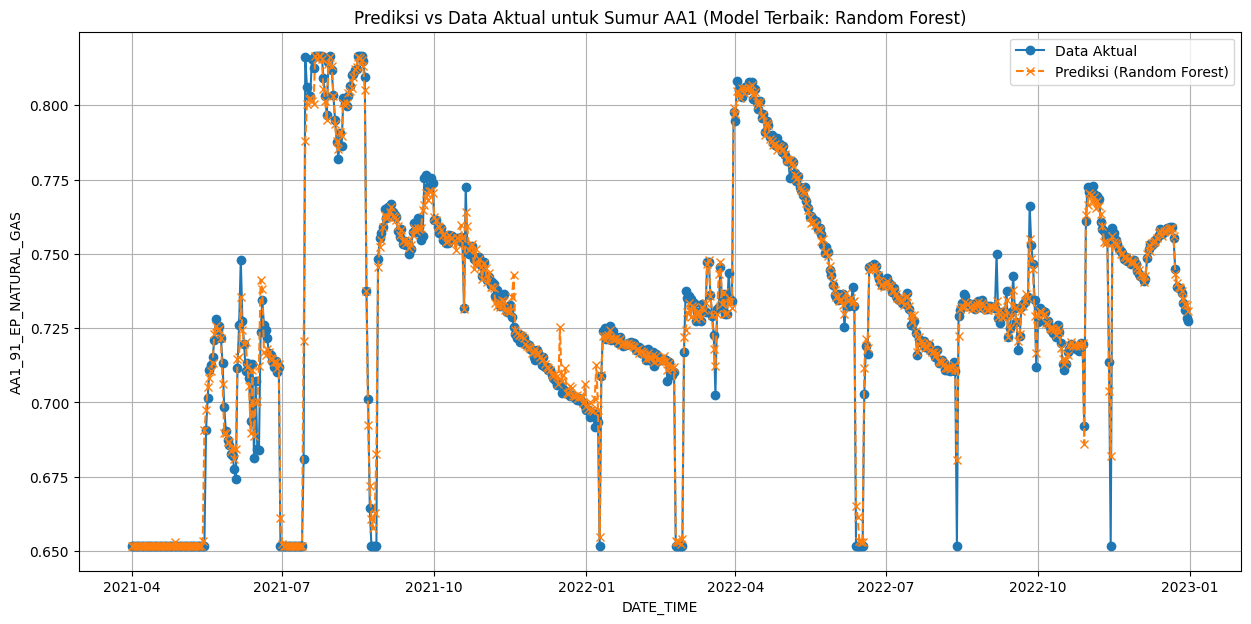


Model terbaik untuk Sumur AA2: XGBoost


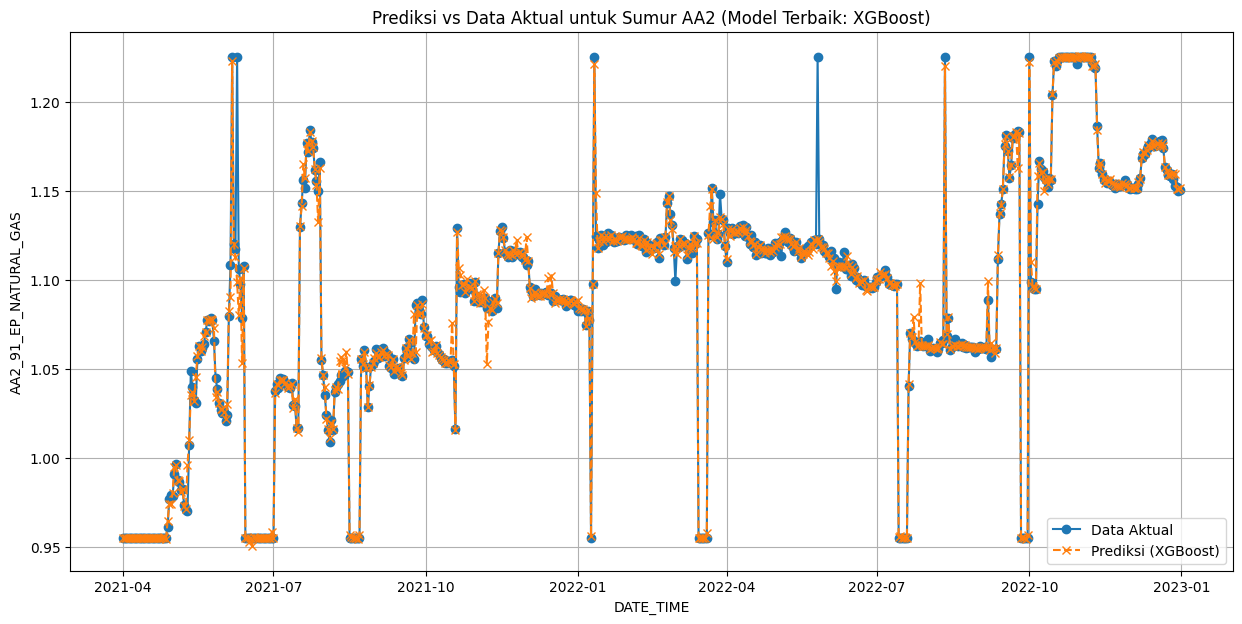


Model terbaik untuk Sumur AA3: Random Forest


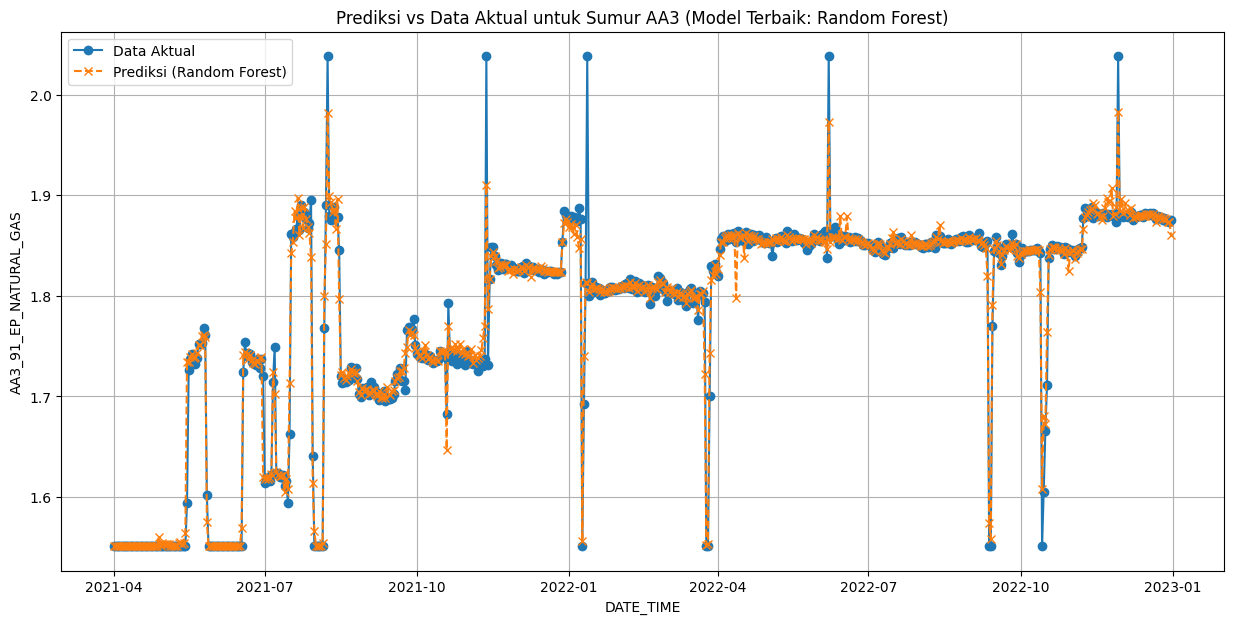


Model terbaik untuk Sumur AA4: Random Forest


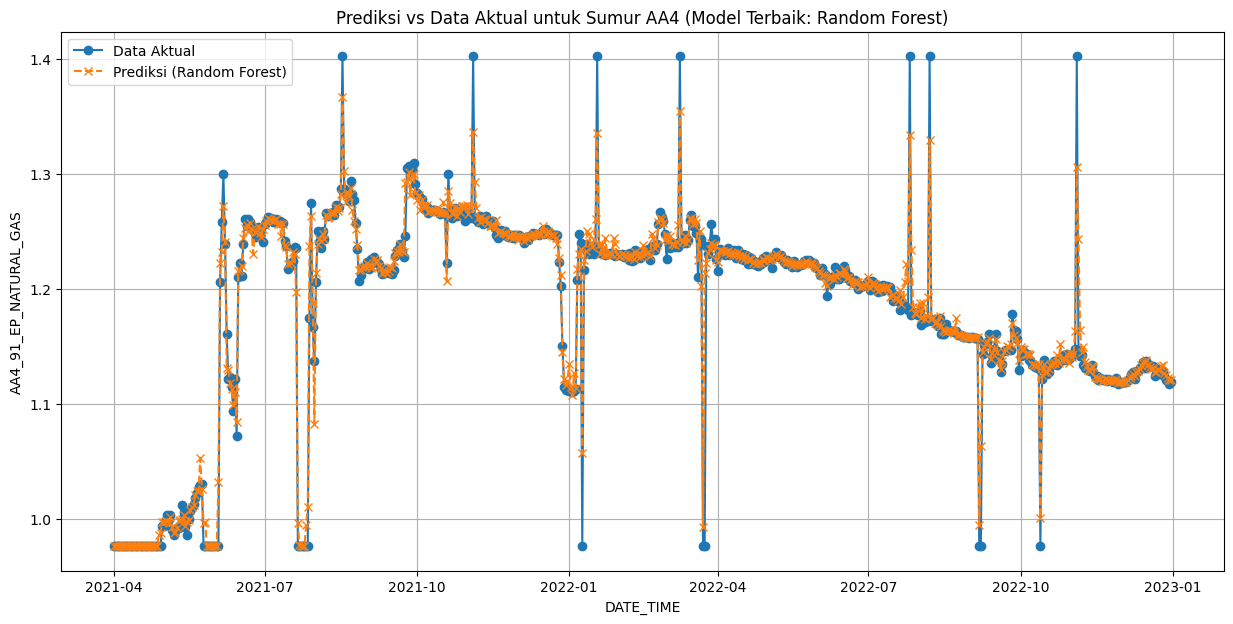


Model terbaik untuk Sumur AA5: Random Forest


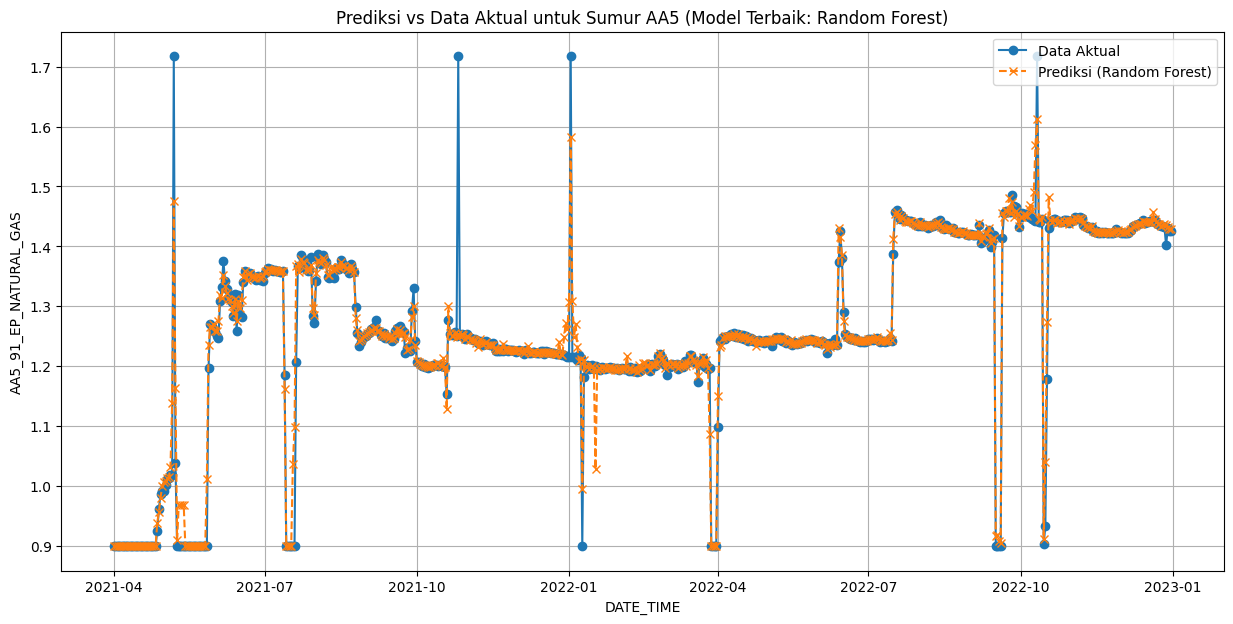

In [ ]:
# prompt: Buatkan grafik yang dapat melihatkan grafik prediksi dan data aktual dengan hasil RMSE paling kecil dan r^2 paling besar

# Function to find the best model based on RMSE and R2
def find_best_model(results):
    best_model_name = None
    best_rmse = float('inf')
    best_r2 = -float('inf')

    for name, metrics in results.items():
        if metrics['RMSE'] < best_rmse and metrics['R2'] > best_r2:
            best_rmse = metrics['RMSE']
            best_r2 = metrics['R2']
            best_model_name = name
        elif metrics['RMSE'] == best_rmse and metrics['R2'] > best_r2:
            best_r2 = metrics['R2']
            best_model_name = name
        elif metrics['RMSE'] < best_rmse and metrics['R2'] == best_r2:
             best_rmse = metrics['RMSE']
             best_model_name = name


    return best_model_name

# Function to plot actual vs predicted values for the best model
def plot_best_model_prediction(df, well_name, best_model_name, model_info):
    X = df[wells[well_name]['features']]
    y = df[wells[well_name]['target']]

    # Use the trained model and scaler from the results
    best_model = model_info['model']
    scaler = model_info['scaler']

    # Scale the features
    X_scaled = scaler.transform(X)

    # Get predictions on the entire dataset (for plotting)
    y_pred = best_model.predict(X_scaled)

    plt.figure(figsize=(15, 7))
    plt.plot(df['DATE_TIME'], y, label='Data Aktual', marker='o', linestyle='-')
    plt.plot(df['DATE_TIME'], y_pred, label=f'Prediksi ({best_model_name})', marker='x', linestyle='--')
    plt.title(f'Prediksi vs Data Aktual untuk Sumur {well_name} (Model Terbaik: {best_model_name})')
    plt.xlabel('DATE_TIME')
    plt.ylabel(f'{well_name}_91_EP_NATURAL_GAS')
    plt.legend()
    plt.grid(True)
    plt.show()

# Iterate through each well, find the best model, and plot the results
for well_name, results in all_results.items():
    best_model_name = find_best_model(results)
    print(f"\nModel terbaik untuk Sumur {well_name}: {best_model_name}")

    # Get the model and scaler info for the best model
    best_model_info = results[best_model_name]

    # Plot the actual vs predicted for the best model
    plot_best_model_prediction(df, well_name, best_model_name, best_model_info)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Create future dates for prediction
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
print("Generating predictions for period:", start_date.strftime('%Y-%m-%d'), "to", end_date.strftime('%Y-%m-%d'))

# Dictionary to store predictions for each well
predictions_dict = {}

# Train XGBoost model and make predictions for each well
for well_prefix in ['AA1', 'AA2', 'AA3', 'AA4', 'AA5']:
    print(f"\nTraining XGBoost model for {well_prefix}")

    # Select features and target for current well
    features = [f"{well_prefix}_91_9500062414", f"{well_prefix}_ANPR", f"{well_prefix}_ANTP",
                f"{well_prefix}_C_OP", f"{well_prefix}_C_PR", f"{well_prefix}_C_TE",
                f"{well_prefix}_FBHP", f"{well_prefix}_FBHT", f"{well_prefix}_FTHP",
                f"{well_prefix}_FTHT"]
    target = f"{well_prefix}_91_EP_NATURAL_GAS"

    X = df[features]
    y = df[target]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train XGBoost model on all data
    model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)

    # Generate synthetic future features based on historical patterns
    # Using mean values from last 30 days as a baseline
    last_30_days = X.tail(30).mean()

    # Create future features matrix
    n_days = len(future_dates)
    future_features = np.tile(last_30_days.values, (n_days, 1))

    # Add some random variation to make it more realistic
    np.random.seed(42)
    variation = np.random.normal(0, 0.1, future_features.shape)
    future_features = future_features * (1 + variation)

    # Scale future features
    future_features_scaled = scaler.transform(future_features)

    # Make predictions
    predictions = model.predict(future_features_scaled)

    # Store predictions
    predictions_dict[well_prefix] = predictions

# Create DataFrame with predictions
forecast_df = pd.DataFrame(index=future_dates)
for well_prefix in predictions_dict.keys():
    forecast_df[f"{well_prefix}_91_EP_NATURAL_GAS"] = predictions_dict[well_prefix]

# Save forecasts to CSV
forecast_df.to_csv('gas_production_forecast_2023.csv')
print("\nForecast summary:")
print(forecast_df.describe())

# Display first few rows of predictions
print("\nFirst few days of predictions:")
print(forecast_df.head())

Generating predictions for period: 2023-01-01 to 2023-12-31

Training XGBoost model for AA1

Training XGBoost model for AA2

Training XGBoost model for AA3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Training XGBoost model for AA4


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Training XGBoost model for AA5

Forecast summary:
       AA1_91_EP_NATURAL_GAS  AA2_91_EP_NATURAL_GAS  AA3_91_EP_NATURAL_GAS  \
count             365.000000             365.000000             365.000000   
mean                0.733866               1.129399               1.796563   
std                 0.037274               0.056544               0.084163   
min                 0.639308               0.942965               1.565992   
25%                 0.708437               1.113625               1.729562   
50%                 0.733532               1.143361               1.822285   
75%                 0.764958               1.165952               1.861200   
max                 0.814251               1.219005               1.964092   

       AA4_91_EP_NATURAL_GAS  AA5_91_EP_NATURAL_GAS  
count             365.000000             365.000000  
mean                1.125118               1.296854  
std                 0.061255               0.203880  
min                 0.995220  

In [ ]:
df_predcited = pd.read_csv('gas_production_forecast_2023.csv')
df_predcited.head()

Unnamed: 0  AA1_91_EP_NATURAL_GAS  AA2_91_EP_NATURAL_GAS  \
0  2023-01-01               0.741123               1.156822   
1  2023-01-02               0.708587               1.119593   
2  2023-01-03               0.707900               1.133589   
3  2023-01-04               0.705944               1.146243   
4  2023-01-05               0.782122               1.115146   

   AA3_91_EP_NATURAL_GAS  AA4_91_EP_NATURAL_GAS  AA5_91_EP_NATURAL_GAS  
0               1.879942               1.139615               1.575932  
1               1.832718               1.129112               1.061338  
2               1.815149               1.116410               1.188181  
3               1.616756               1.189004               1.252438  
4               1.735516               1.157376               1.448565

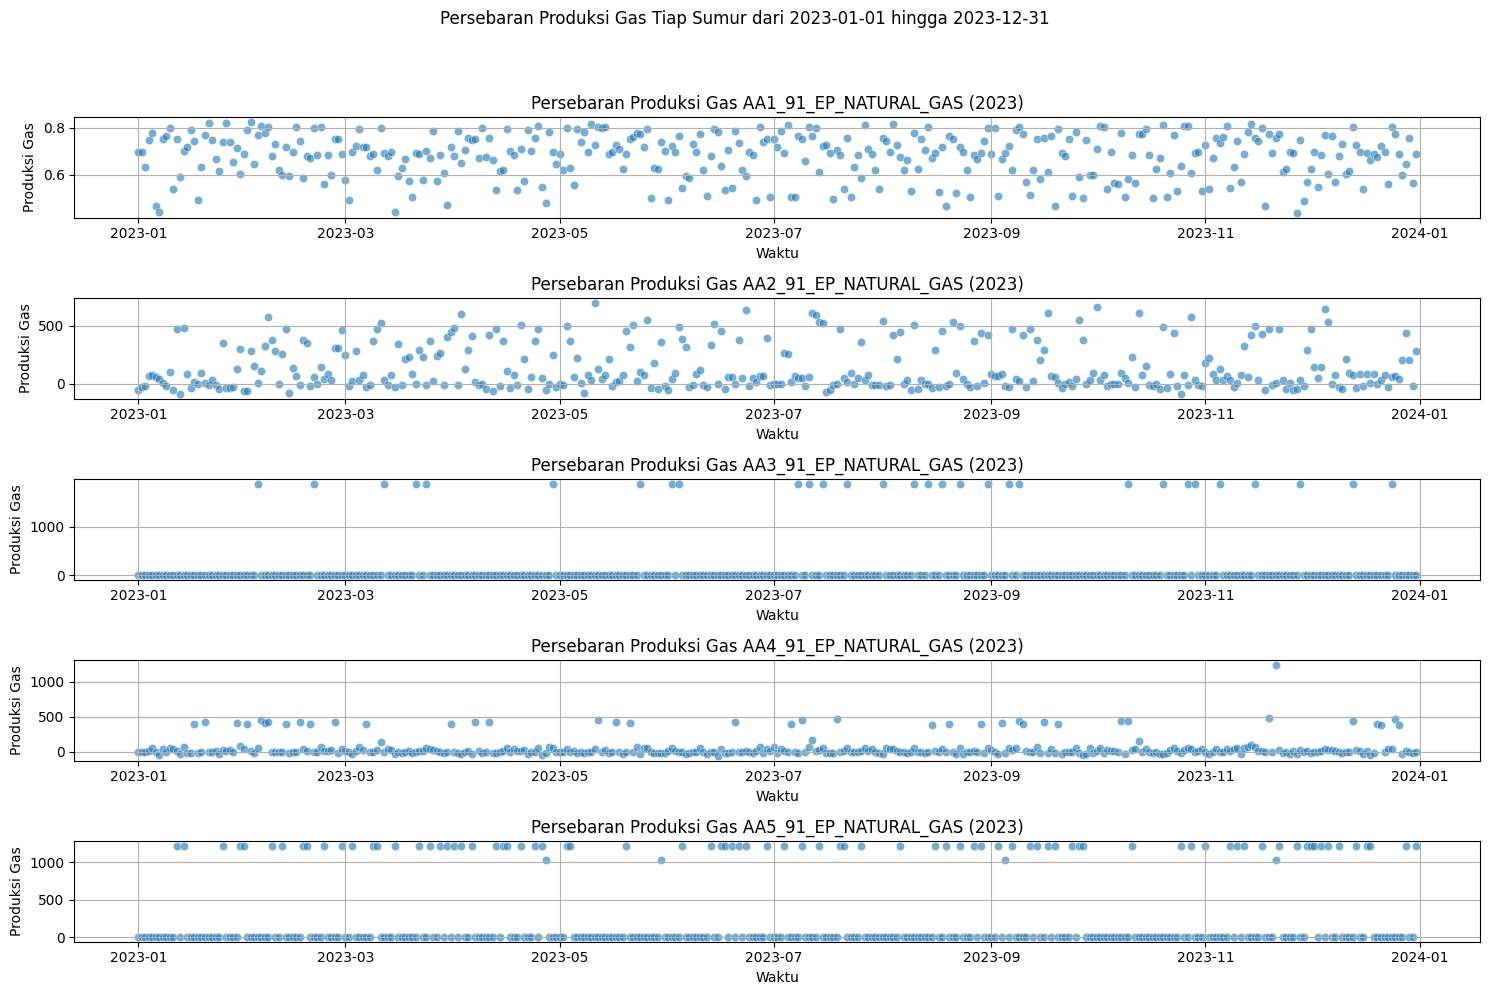

In [ ]:
# prompt: Buat grafik persebaran untuk setiap waktu dari hasil gas produksi tiap sumur dari tahun 2023-01-01  sampai 2023-12-31

# Filter data for the specified date range
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
df_predcited['Unnamed: 0'] = pd.to_datetime(df_predcited['Unnamed: 0'])
forecast_df_filtered = df_predcited[(df_predcited['Unnamed: 0'] >= start_date) & (df_predcited['Unnamed: 0'] <= end_date)].copy()

# Rename the date column for clarity
forecast_df_filtered.rename(columns={'Unnamed: 0': 'DATE_TIME'}, inplace=True)

# Get the list of well columns (gas production)
well_columns = [col for col in forecast_df_filtered.columns if '_91_EP_NATURAL_GAS' in col]

# Create scatter plots for each well's gas production over time
plt.figure(figsize=(15, 10))

for i, well_col in enumerate(well_columns):
    plt.subplot(len(well_columns), 1, i + 1)
    sns.scatterplot(data=forecast_df_filtered, x='DATE_TIME', y=well_col, alpha=0.6)
    plt.title(f'Persebaran Produksi Gas {well_col} (2023)')
    plt.xlabel('Waktu')
    plt.ylabel('Produksi Gas')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap

plt.suptitle('Persebaran Produksi Gas Tiap Sumur dari 2023-01-01 hingga 2023-12-31', y=1.02)
plt.show()

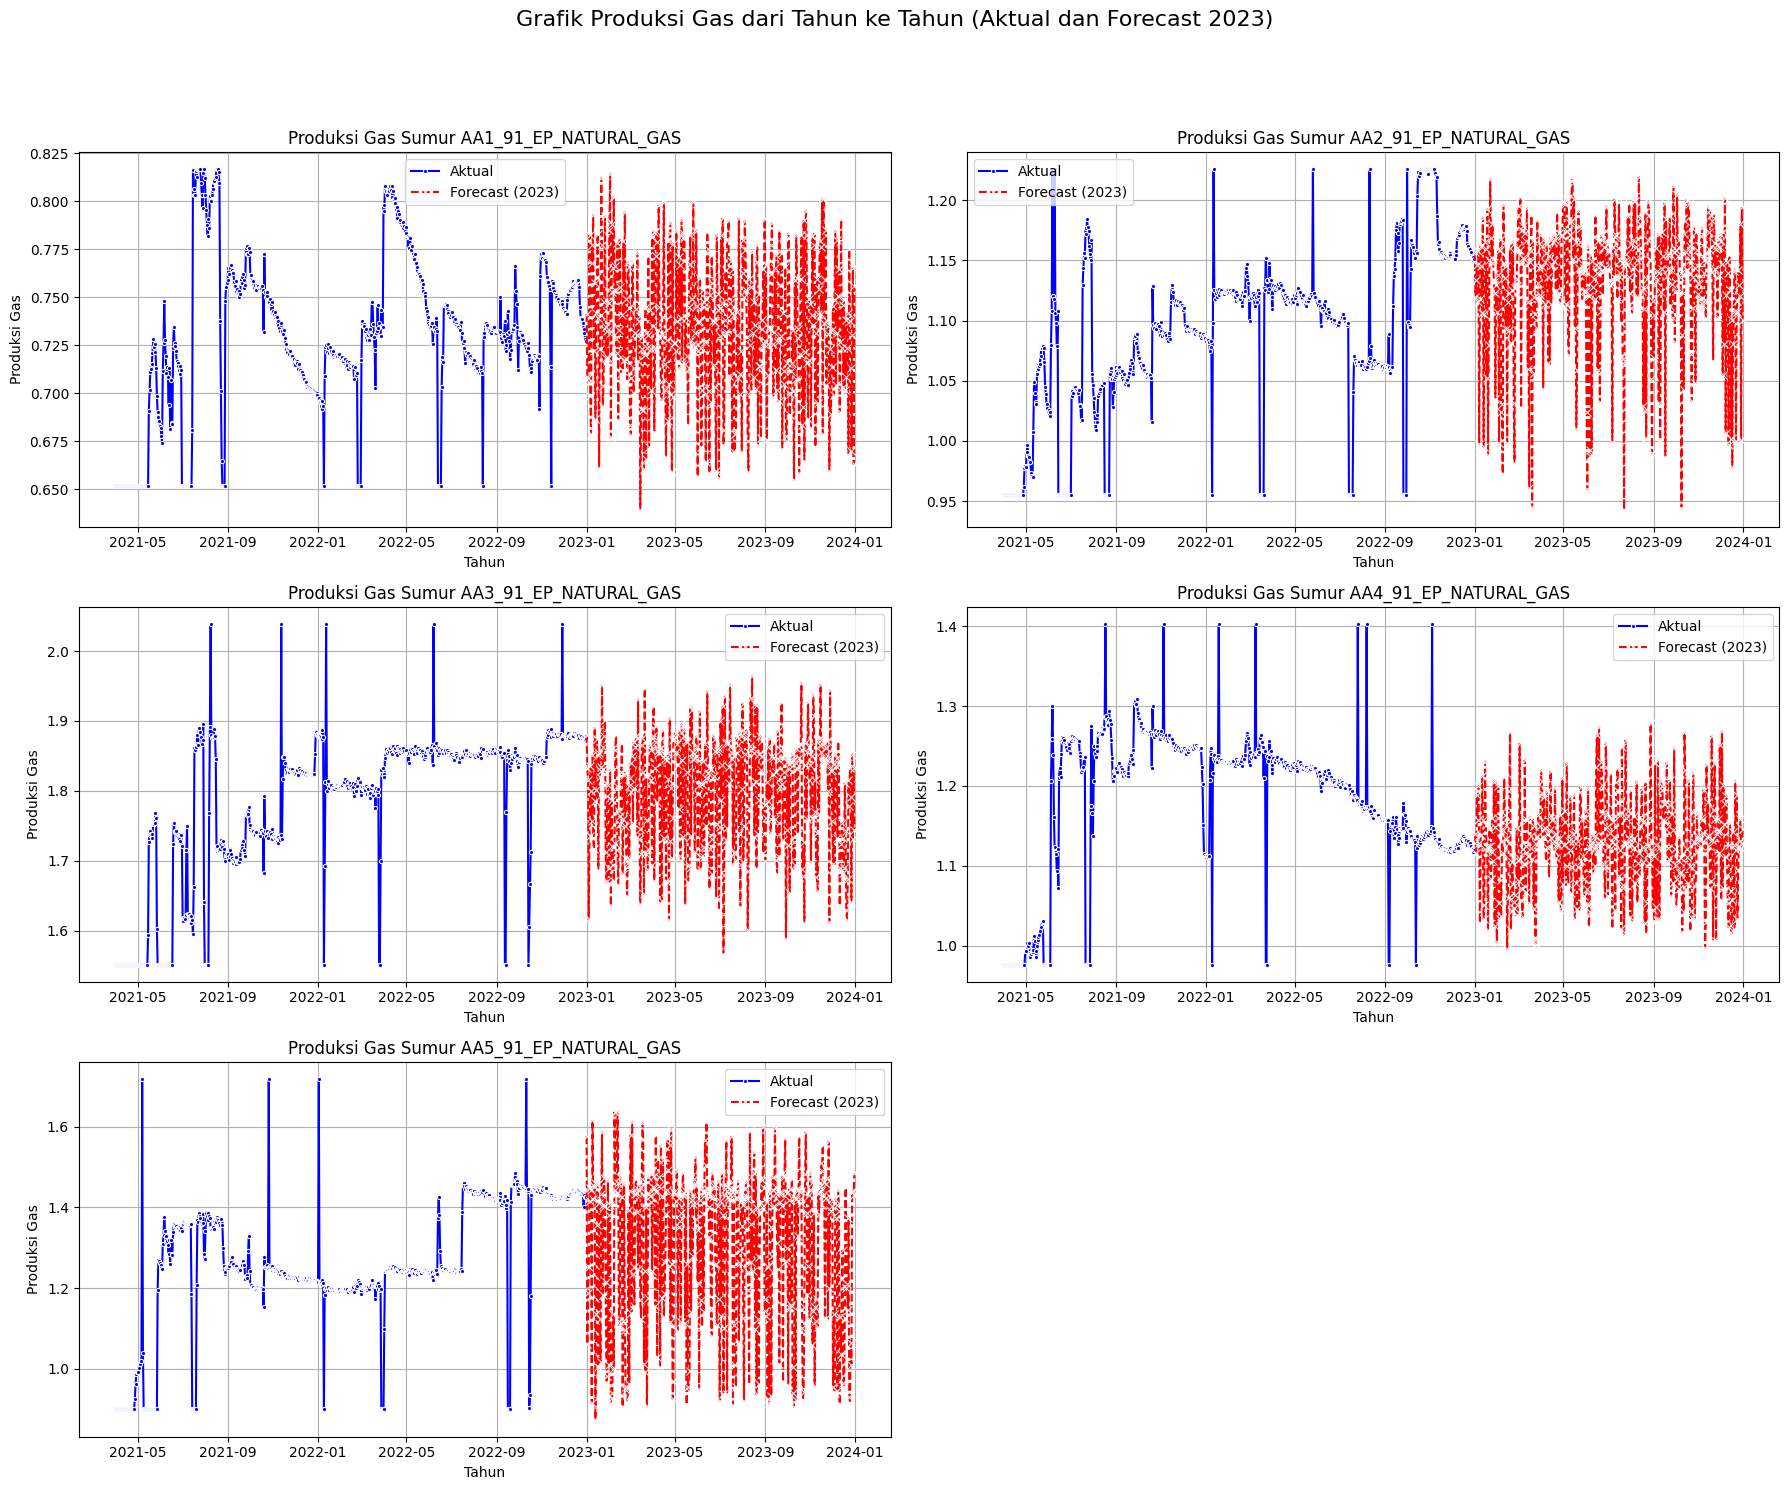

In [ ]:
# prompt: Buatkan grafik gas produksi dari tahun ke tahun buat tahun 2023 hasil forecast beda warna, buat grafik tiap sumur

# Combine actual and forecast data for plotting
df_combined = df.copy()
# We will add the 'Type' column later after selecting specific columns


# Re-define forecast_df_filtered by reading the CSV and filtering
# This ensures it is available in this cell
df_predcited = pd.read_csv('gas_production_forecast_2023.csv')
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
df_predcited['Unnamed: 0'] = pd.to_datetime(df_predcited['Unnamed: 0'])
forecast_df_filtered = df_predcited[(df_predcited['Unnamed: 0'] >= start_date) & (df_predcited['Unnamed: 0'] <= end_date)].copy()

# Rename date column in forecast_df_filtered to match df
forecast_df_filtered.rename(columns={'Unnamed: 0': 'DATE_TIME'}, inplace=True)

# Get the list of gas production columns common to both actual and forecast
gas_cols = [col for col in df.columns if '_91_EP_NATURAL_GAS' in col]

# Select relevant columns from actual data
actual_cols_to_keep = ['DATE_TIME'] + gas_cols
df_actual_gas = df_combined[actual_cols_to_keep].copy()
df_actual_gas['Type'] = 'Aktual' # Add 'Type' column here

# Select relevant columns from forecast data
forecast_cols_to_keep = ['DATE_TIME'] + gas_cols # Ensure only common gas columns are selected
df_forecast_gas = forecast_df_filtered[forecast_cols_to_keep].copy()
df_forecast_gas['Type'] = 'Forecast (2023)' # Add 'Type' column here


# Ensure columns are in the same order before concatenating
df_forecast_gas = df_forecast_gas[df_actual_gas.columns]


# Concatenate the dataframes
# Use ignore_index=True to create a new default index
df_combined_plot = pd.concat([df_actual_gas, df_forecast_gas], ignore_index=True)


# Melt the dataframe for easier plotting with seaborn
df_melted = df_combined_plot.melt(id_vars=['DATE_TIME', 'Type'],
                                  var_name='Well',
                                  value_name='Gas Production')

# Get the list of unique wells
wells = df_melted['Well'].unique()

# Plot gas production for each well
plt.figure(figsize=(18, 15))
n_wells = len(wells)
n_cols_plot = 2 # Number of columns for subplots
n_rows_plot = int(np.ceil(n_wells / n_cols_plot))

for i, well in enumerate(wells):
    plt.subplot(n_rows_plot, n_cols_plot, i + 1)
    well_data_melted = df_melted[df_melted['Well'] == well]

    # Plot actual data
    sns.lineplot(data=well_data_melted[well_data_melted['Type'] == 'Aktual'],
                 x='DATE_TIME',
                 y='Gas Production',
                 label='Aktual',
                 color='blue',
                 marker='.')

    # Plot forecast data (2023)
    sns.lineplot(data=well_data_melted[well_data_melted['Type'] == 'Forecast (2023)'],
                 x='DATE_TIME',
                 y='Gas Production',
                 label='Forecast (2023)',
                 color='red',
                 linestyle='--',
                 marker='x')

    plt.title(f'Produksi Gas Sumur {well}')
    plt.xlabel('Tahun')
    plt.ylabel('Produksi Gas')
    plt.legend()
    plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.suptitle('Grafik Produksi Gas dari Tahun ke Tahun (Aktual dan Forecast 2023)', y=1.02, fontsize=16)
plt.show()